Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=63
num_BackTrack_Days=6

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
#
drop_n_dataset_days=520
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
254                                           NaN                 Tunisia   
255                                           NaN                  Turkey   
256                                           NaN           United States   
257                                           NaN                  Uganda   
258                                           NaN                 Ukraine   
259                                           NaN    United Arab Emirates   
260                                      Anguilla          United Kingdom   
261                                       Bermuda          United Kingdom   
262                        British Virgin Islands          United Kingdom   
263                                Cayman Islands          United Kingdom   
264                               Channel Islands          United Kingdom   
265                   Falkland Islands (Malvinas)          United Kingdom   
266                                     Gibraltar          United Kingdom   
267                                      Guernsey          United Kingdom   
268                                   Isle of Man          United Kingdom   
269                                        Jersey          United Kingdom   
270                                    Montserrat          United Kingdom   
271  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
272                      Turks and Caicos Islands          United Kingdom   
273                                           NaN          United Kingdom   
274                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
260                                           NaN                 Tunisia   
261                                           NaN                  Turkey   
262                                           NaN           United States   
263                                           NaN                  Uganda   
264                                           NaN                 Ukraine   
265                                           NaN    United Arab Emirates   
266                                      Anguilla          United Kingdom   
267                                       Bermuda          United Kingdom   
268                        British Virgin Islands          United Kingdom   
269                                Cayman Islands          United Kingdom   
270                               Channel Islands          United Kingdom   
271                   Falkland Islands (Malvinas)          United Kingdom   
272                                     Gibraltar          United Kingdom   
273                                      Guernsey          United Kingdom   
274                                   Isle of Man          United Kingdom   
275                                        Jersey          United Kingdom   
276                                    Montserrat          United Kingdom   
277  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
278                      Turks and Caicos Islands          United Kingdom   
279                                           NaN          United Kingdom   
280                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  3/7/22  3/8/22  3/9/22  3/10/22  \
185        0        0        0        0  ...     725     725     725      726   
186        0        0        0        0  ...     609     610     612      613   
187        0        0        0        0  ...       0       0       0        0   
188        0        0        0        0  ...     980     980     981      981   
189        0        0        0        0  ...     904     904     904      934   
190        0        0        0        0  ...  319901  320166  320408   320607   
191        0        0        0        0  ...       0       0       0        0   
192        0        0        0        0  ...   11293   11298   11304    11319   
193        0        0        0        0  ...      51      51      51       51   
194        0        0        0        0  ...    2176    2176    2177     2177   

     3/11/22  3/12/22  3/13/22  3/14/22   Population                 region  
185      726      726      726      726    20,250,833              Mali_nan  
186      613      614      614      615       441,543             Malta_nan  
187        0        0        0        0           NaN  Marshall Islands_nan  
188      981      981      981      981     4,649,658        Mauritania_nan  
189      934      934      934      934     1,273,985         Mauritius_nan  
190   320607   321054   321103   321115   128,640,794            Mexico_nan  
191        0        0        0        0           NaN        Micronesia_nan  
192    11333    11339    11346    11350     4,035,942           Moldova_nan  
193       51       51       52       52        39,183            Monaco_nan  
194     2177     2177     2177     2177     3,278,290          Mongolia_nan  

[10 rows x 789 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN        Moldova  47.411600   28.36990   
176                               NaN         Monaco  43.733300    7.41670   
177                               NaN       Mongolia  46.862500  103.84670   
178                               NaN     Montenegro  42.708678   19.37439   
179                               NaN        Morocco  31.791700   -7.09260   
180                               NaN     Mozambique -18.665700   35.52960   
181                               NaN        Namibia -22.957600   18.49040   
182                               NaN          Nepal  28.166700   84.25000   
183                             Aruba    Netherlands  12.521100  -69.96830   
184  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  3/7/22  \
175        0        0        0        0        0        0  ...       0   
176        0        0        0        0        0        0  ...       0   
177        0        0        0        0        0        0  ...       0   
178        0        0        0        0        0        0  ...       0   
179        0        0        0        0        0        0  ...       0   
180        0        0        0        0        0        0  ...       0   
181        0        0        0        0        0        0  ...       0   
182        0        0        0        0        0        0  ...       0   
183        0        0        0        0        0        0  ...       0   
184        0        0        0        0        0        0  ...       0   

     3/8/22  3/9/22  3/10/22  3/11/22  3/12/22  3/13/22  3/14/22  \
175       0       0        0        0        0        0        0   
176       0       0        0        0        0        0        0   
177       0       0        0        0        0        0        0   
178       0       0        0        0        0        0        0   
179       0       0        0        0        0        0        0   
180       0       0        0        0        0        0        0   
181       0       0        0        0        0        0        0   
182       0       0        0        0        0        0        0   
183       0       0        0        0        0        0        0   
184       0       0        0        0        0        0        0   

      Population                                         region  
175     4,035,942                                   Moldova_nan  
176        39,183                                    Monaco_nan  
177     3,278,290                                  Mongolia_nan  
178       622 500                                Montenegro_nan  
179    36,817,128                                   Morocco_nan  
180    31,542,919                                Mozambique_nan  
181     2,540,905                                   Namibia_nan  
182    29,300,000                                     Nepal_nan  
183       116,600                             Netherlands_Aruba  
184        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 789 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   3/7/22   3/8/22   3/9/22  \
185        0        0        0        0  ...    30398    30401    30402   
186        0        0        0        0  ...    71971    72130    72268   
187        0        0        0        0  ...        7        7        7   
188        0        0        0        0  ...    58652    58654    58656   
189        0        0        0        0  ...   169796   169796   169796   
190        0        0        0        0  ...  5566669  5575608  5583993   
191        0        0        0        0  ...        1        1        1   
192        0        0        0        0  ...   505644   505996   506222   
193        0        0        0        0  ...     9539     9605     9654   
194        0        0        0        0  ...   913255   913444   914016   

     3/10/22  3/11/22  3/12/22  3/13/22  3/14/22   Population   \
185    30407    30409    30414    30420    30423    20,250,833   
186    72421    72560    72687    72858    73001       441,543   
187        7        7        7        7        7           NaN   
188    58657    58657    58657    58658    58659     4,649,658   
189   181362   181362   181362   181362   181362     1,273,985   
190  5591871  5591871  5605636  5606827  5607845   128,640,794   
191        1        1        1        1        1           NaN   
192   506681   507028   507599   507994   508235     4,035,942   
193     9654     9736     9777     9777     9827        39,183   
194   914536   914536   914536   914536   915811     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 789 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                            Poland  51.919400   19.145100   
221            NaN                          Portugal  39.399900   -8.224500   
222            NaN                             Qatar  25.354800   51.183900   
223            NaN                           Romania  45.943200   24.966800   
224            NaN                            Russia  61.524010  105.318756   
225            NaN                            Rwanda  -1.940300   29.873900   
226            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
227            NaN                       Saint Lucia  13.909400  -60.978900   
228            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
229            NaN                             Samoa -13.759000 -172.104600   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...    3/7/22  \
220        0        0        0        0        0        0  ...   5747322   
221        0        0        0        0        0        0  ...   3337806   
222        0        0        0        0        0        0  ...    358418   
223        0        0        0        0        0        0  ...   2771449   
224        0        0        0        0        0        0  ...  16770275   
225        0        0        0        0        0        0  ...    129560   
226        0        0        0        0        0        0  ...      5536   
227        0        0        0        0        0        0  ...     22795   
228        0        0        0        0        0        0  ...      8320   
229        0        0        0        0        0        0  ...        41   

       3/8/22    3/9/22   3/10/22   3/11/22   3/12/22   3/13/22   3/14/22  \
220   5760498   5774938   5788363   5799996   5811109   5818687   5823982   
221   3352874   3367469   3380263   3380263   3380263   3380263   3413013   
222    358564    358694    358821    358946    359028    359149    359259   
223   2776910   2781086   2784651   2787625   2790368   2791994   2794081   
224  16835844  16893631  16943915  16993625  17040721  17084672  17124792   
225    129567    129569    129576    129589    129596    129601    129602   
226      5537      5537      5538      5538      5540      5540      5541   
227     22808     22811     22822     22833     22833     22847     22853   
228      8321      8321      8321      8323      8323      8323      8323   
229        41        41        45        46        48        48        48   

      Population                                 region  
220    37,980,000                            Poland_nan  
221    10,290,000                          Portugal_nan  
222     2,870,256                             Qatar_nan  
223    19,530,000                           Romania_nan  
224   144,500,000                            Russia_nan  
225    12,952,218                            Rwanda_nan  
226        53,673             Saint Kitts and Nevis_nan  
227       184,106                       Saint Lucia_nan  
228       110,940  Saint Vincent and the Grenadines_nan  
229           NaN                             Samoa_nan  

[10 rows x 789 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

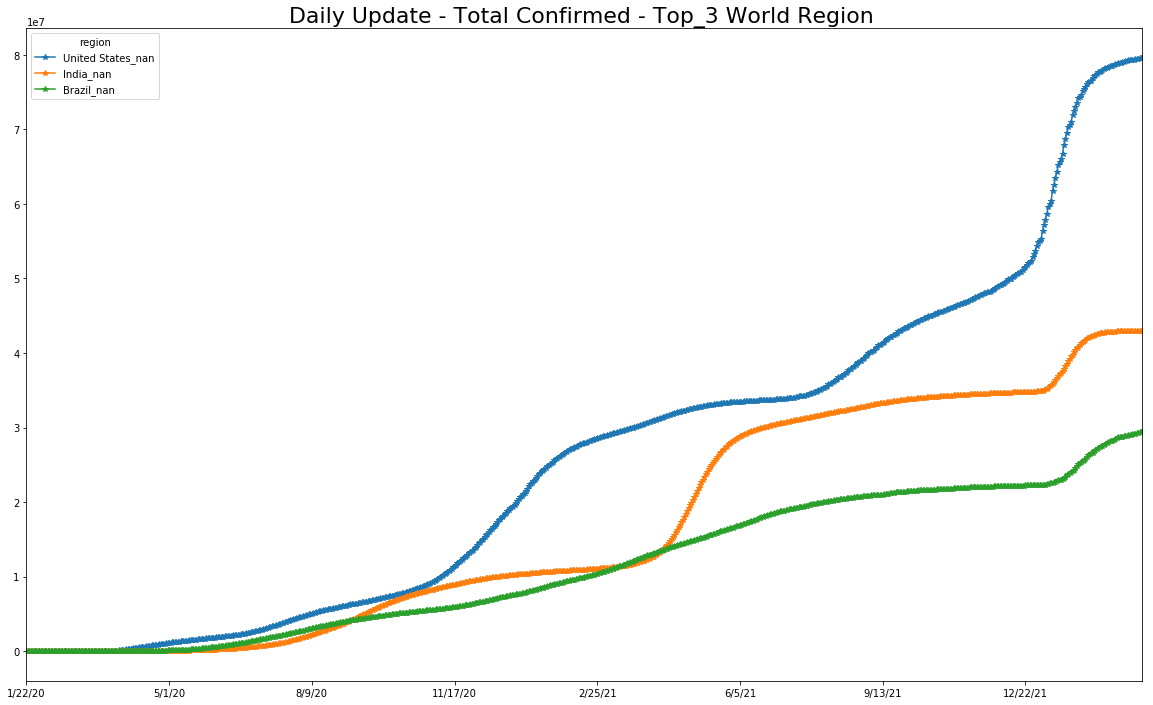

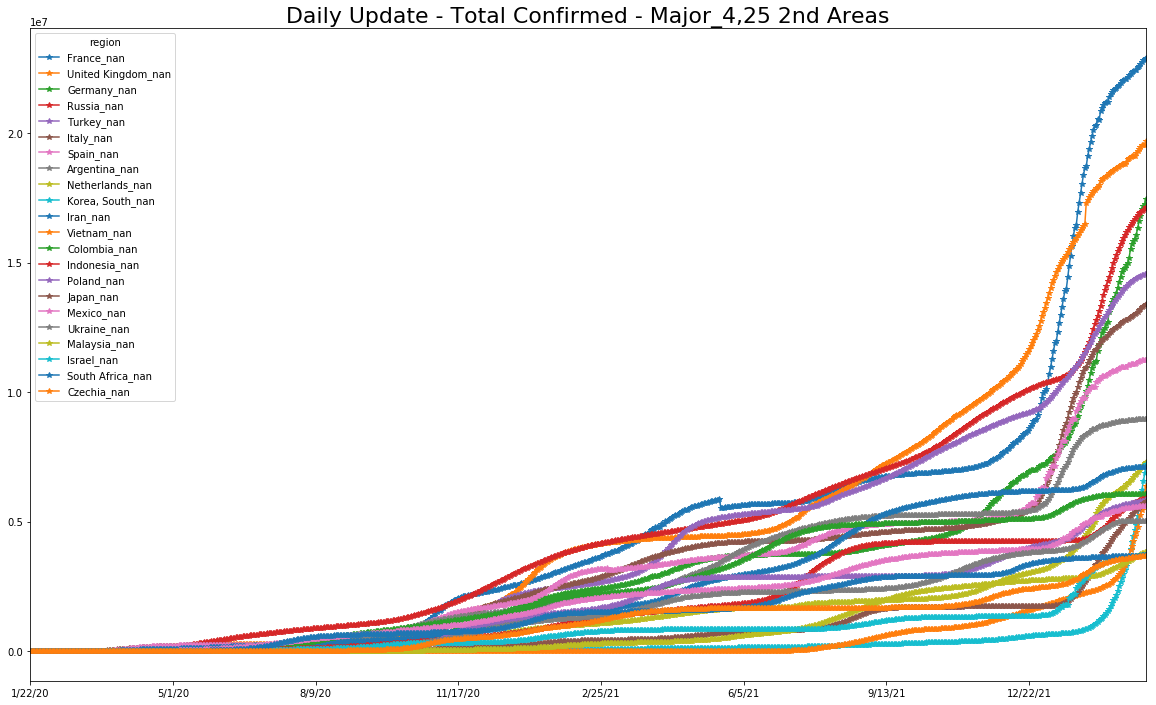

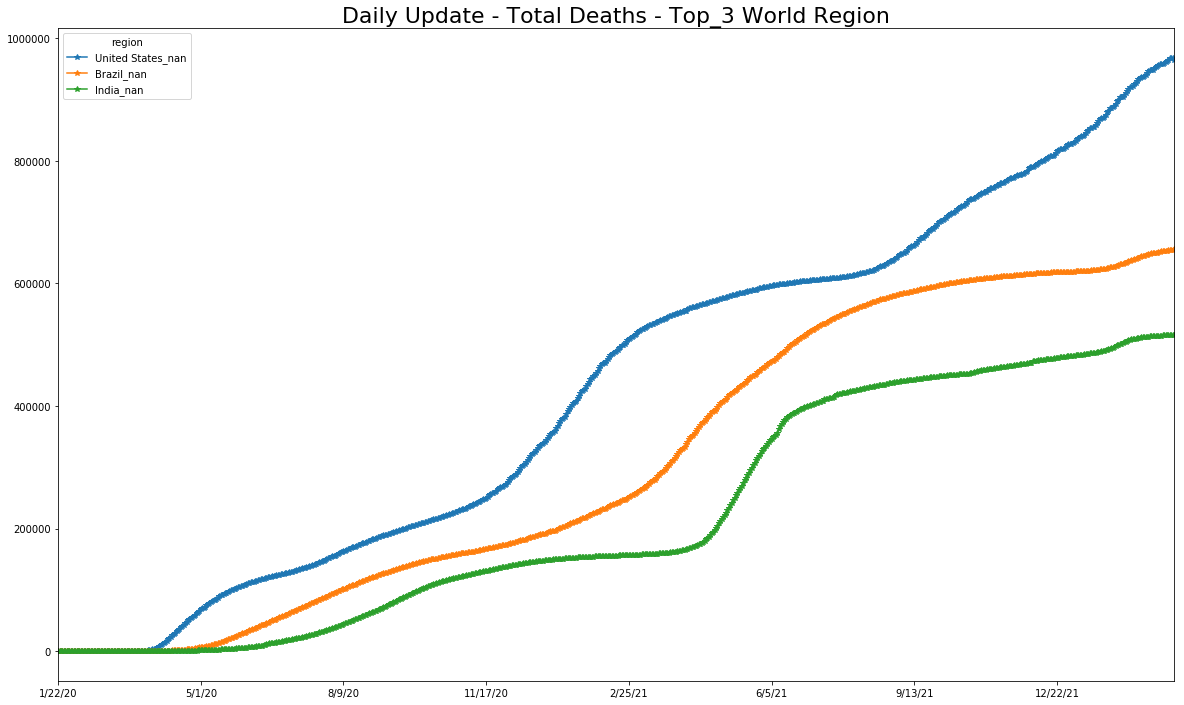

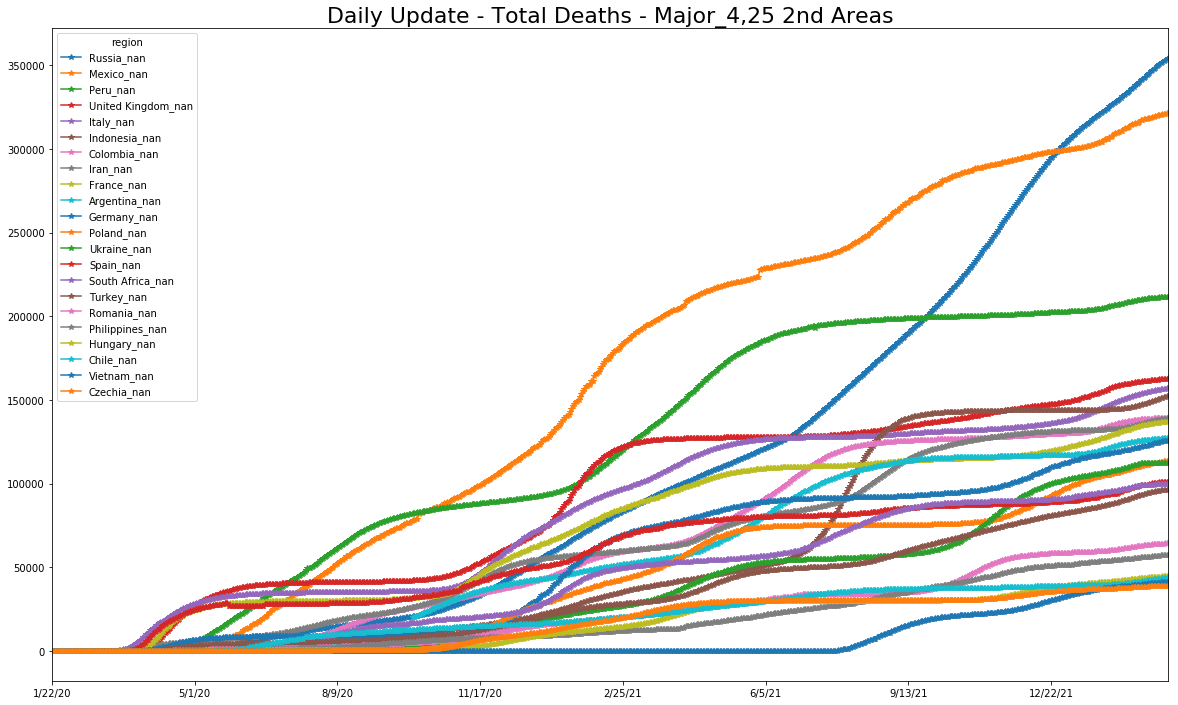

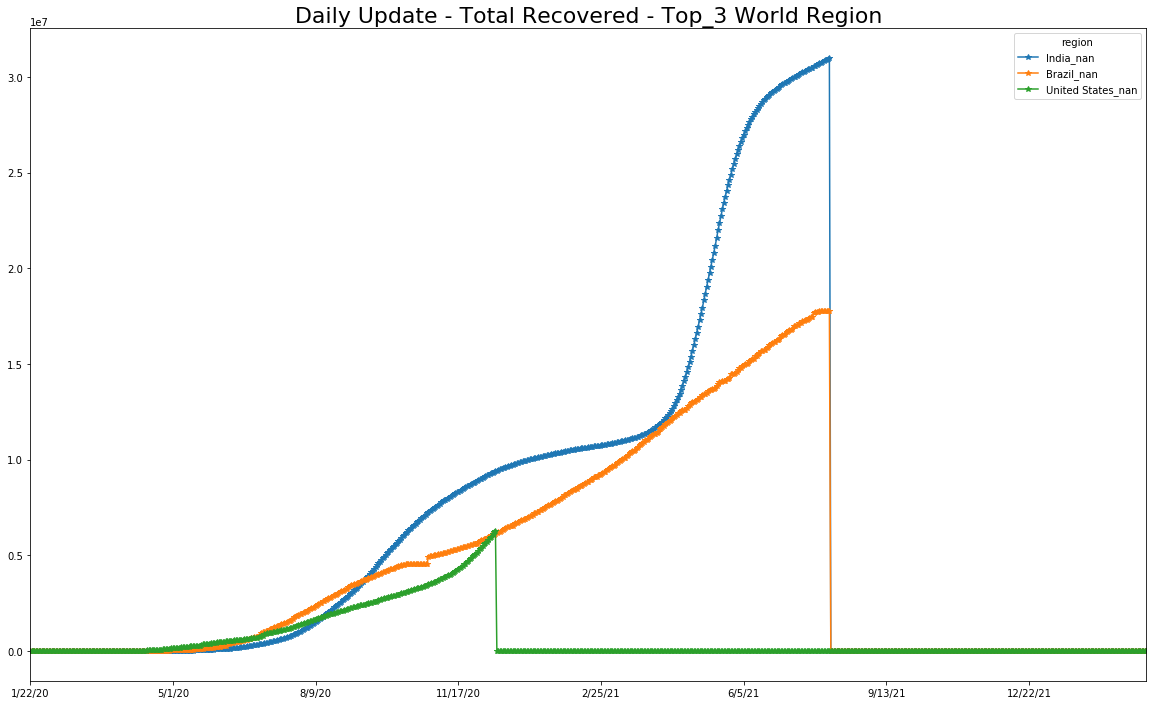

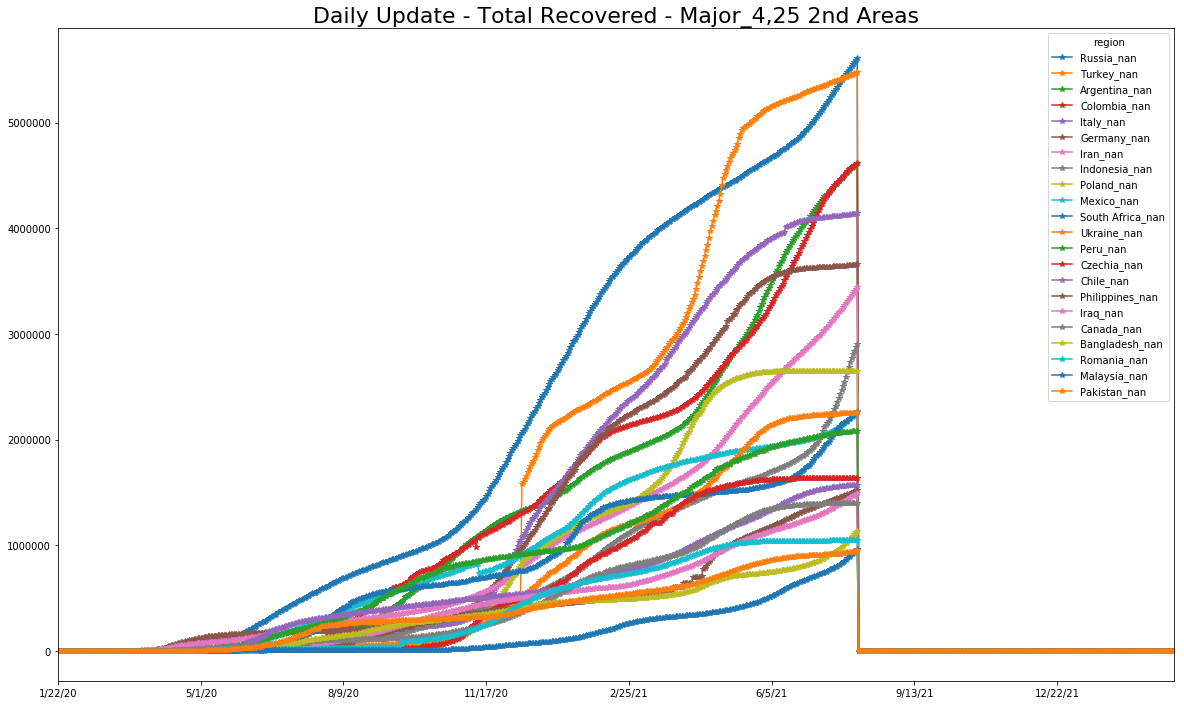

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/03/15


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
6/25/21           111592       132506       137772        13882       38371   
6/26/21           113124       132509       138113        13882       38528   
6/27/21           114220       132512       138465        13882       38556   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
6/25/21               0                     1263        4374587       224635   
6/26/21               0                     1263        4393142       224728   
6/27/21               0                     1263        4405247       224797   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
6/25/21                                     124  ...       363580   
6/26/21                                     124  ...       364859   
6/27/21                                     124  ...       365866   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
6/25/21          108184            4         266952        14537   
6/26/21          108730            4         268349        15325   
6/27/21          109223            4         269635        15740   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
6/25/21                  313520                         0       6905   
6/26/21                  313520                         0       6906   
6/27/21                  313721                         0       6908   

region   Zambia_nan  Zimbabwe_nan  
6/25/21      143215         45217  
6/26/21      146031         46018  
6/27/21      148568         46442  

[3 rows x 284 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
3/11/22           175974       272552       265391        38794       98855   
3/12/22           176039       272621       265410        38794       98909   
3/13/22           176201       272663       265432        38794       98927   
3/14/22           176409       272689       265457        38794       98931   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
3/11/22              11                     7466        8967210       421842   
3/12/22              11                     7466        8970196       421953   
3/13/22              11                     7466        8971432       422004   
3/14/22              11                     7466        8976079       422021   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
3/11/22                                   58687  ...       862153   
3/12/22                                   59305  ...       863365   
3/13/22                                   59881  ...       864376   
3/14/22                                   60654  ...       865644   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
3/11/22          237129          164         517720      5448935   
3/12/22          237169          207         517999      5903147   
3/13/22          237238          207         518410      6112648   
3/14/22          237260          259         518410      6377438   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
3/11/22                  653293                       535      11783   
3/12/22                  653293                       535      11784   
3/13/22                  653293                       535      11784   
3/14/22                  653854                       535      11793   

region   Zambia_nan  Zimbabwe_nan  
3/11/22      314986        241548  
3/12/22      315148        242069  
3/13/22      315202        242515  
3/14/22      315202        242909  

[4 rows x 284 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-06-26  Afghanistan_nan     113124             0             0   
2     2021-06-27  Afghanistan_nan     114220          1532             0   
3     2021-06-28  Afghanistan_nan     115751          1096             0   
4     2021-06-29  Afghanistan_nan     117158          1531          4159   
5     2021-06-30  Afghanistan_nan     118659          1407          4034   
6     2021-07-01  Afghanistan_nan     120216          1501          4439   
7     2021-07-02  Afghanistan_nan     122156          1557          4465   
8     2021-07-03  Afghanistan_nan     123485          1940          4998   
9     2021-07-04  Afghanistan_nan     124748          1329          4826   
10    2021-07-05  Afghanistan_nan     125937          1263          4532   
11    2021-07-06  Afghanistan_nan     127464          1189          3781   
12    2021-07-07  Afghanistan_nan     129021          1527          3979   
13    2021-07-08  Afghanistan_nan     130113          1557          4273   
14    2021-07-09  Afghanistan_nan     131586          1092          4176   
15    2021-07-10  Afghanistan_nan     132777          1473          4122   
16    2021-07-11  Afghanistan_nan     133578          1191          3756   
17    2021-07-12  Afghanistan_nan     134653           801          3465   
18    2021-07-13  Afghanistan_nan     135889          1075          3067   
19    2021-07-14  Afghanistan_nan     136643          1236          3112   
20    2021-07-15  Afghanistan_nan     137853           754          3065   
21    2021-07-16  Afghanistan_nan     139051          1210          3200   
22    2021-07-17  Afghanistan_nan     140224          1198          3162   
23    2021-07-18  Afghanistan_nan     140602          1173          3581   
24    2021-07-19  Afghanistan_nan     141499           378          2749   
25    2021-07-20  Afghanistan_nan     142414           897          2448   
26    2021-07-21  Afghanistan_nan     142762           915          2190   
27    2021-07-22  Afghanistan_nan     143183           348          2160   
28    2021-07-23  Afghanistan_nan     143439           421          1684   
29    2021-07-24  Afghanistan_nan     143666           256          1025   
30    2021-07-25  Afghanistan_nan     143871           227           904   
...          ...              ...        ...           ...           ...   
76530 2022-02-14     Zimbabwe_nan     231603            82           341   
76531 2022-02-15     Zimbabwe_nan     231603           222           389   
76532 2022-02-16     Zimbabwe_nan     232213             0           304   
76533 2022-02-17     Zimbabwe_nan     232598           610           832   
76534 2022-02-18     Zimbabwe_nan     233030           385           995   
76535 2022-02-19     Zimbabwe_nan     233224           432          1427   
76536 2022-02-20     Zimbabwe_nan     233352           194          1011   
76537 2022-02-21     Zimbabwe_nan     233571           128           754   
76538 2022-02-22     Zimbabwe_nan     233980           219           541   
76539 2022-02-23     Zimbabwe_nan     234589           409           756   
76540 2022-02-24     Zimbabwe_nan     234967           609          1237   
76541 2022-02-25     Zimbabwe_nan     235467           378          1396   
76542 2022-02-26     Zimbabwe_nan     235803           500          1487   
76543 2022-02-27     Zimbabwe_nan     235803           336          1214   
76544 2022-02-28     Zimbabwe_nan     236380             0           836   
76545 2022-03-01     Zimbabwe_nan     236871           577           913   
76546 2022-03-02     Zimbabwe_nan     237503           491          1068   
76547 2022-03-03     Zimbabwe_nan     237503           632          1700   
76548 2022-03-04     Zimbabwe_nan     238739             0          1123   
76549 2022-03-05     Zimbabwe_nan     239019          1236          1868   
76550 2022-03-06     Zimbabwe_nan     239209           280  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
76559 2022-03-15  Zimbabwe_nan          0           394          1361   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
76559          3199         100.162468         100.563453         101.334533   

       last_day  kalman_prediction  population  infected_rate  min  max  
76559    242909           243398.0    14862924       0.000163  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
76559 2022-03-15  Zimbabwe_nan          0           394          1361   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
76559          3199         100.162468         100.563453         101.334533   

       last_day  kalman_prediction  population  infected_rate  min  max  
76559    242909           243398.0    14862924       0.000163  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
74973  2022-03-13  Zimbabwe_nan     242515           521          1726   
74974  2022-03-14  Zimbabwe_nan     242909           446           967   
74975  2022-03-15  Zimbabwe_nan          0           394          1361   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
74973          3050         100.215696         100.718144         101.276053   
74974          3306         100.184249         100.400339         101.382059   
74975          3199         100.162468         100.563453         101.334533   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
74973               242069  ...    14862924       0.000163  NaN  NaN   
74974               242515  ...    14862924       0.000163  NaN  NaN   
74975               242909  ...    14862924       0.000163  NaN  NaN   

       population_percentage : infected_rate confirmed  \
74973                                         0.016287   
74974                                         0.016317   
74975                                         0.016343   

       population_percentage : factor 9/10 infected_rate confirmed  \
74973                                           0.146582             
74974                                           0.146852             
74975                                           0.147090             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
74973                   495.0                          33.304348   
74974                   482.0                          32.429689   
74975                   489.0                          32.900659   

       delta : roling 7day AVG  \
74973               435.714286   
74974               472.285714   
74975               457.000000   

       delta : aprox 14-day case notification rate per 100k hab  
74973                                          41.041722         
74974                                          44.486536         
74975                                          43.046711         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
273  United States_nan  2.422672e+13  4.922065e+06  412315.068441


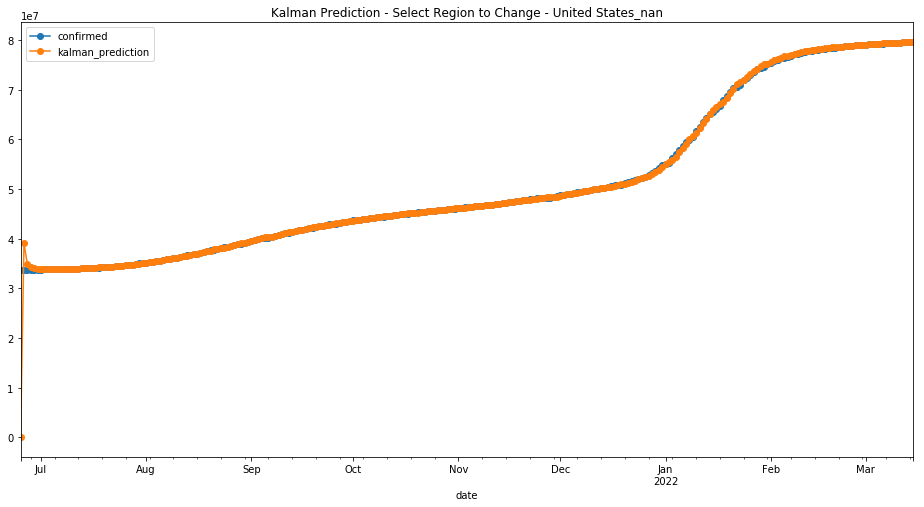

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse          mae
218  Russia_nan  1.126193e+12  1.061222e+06  79780.78327


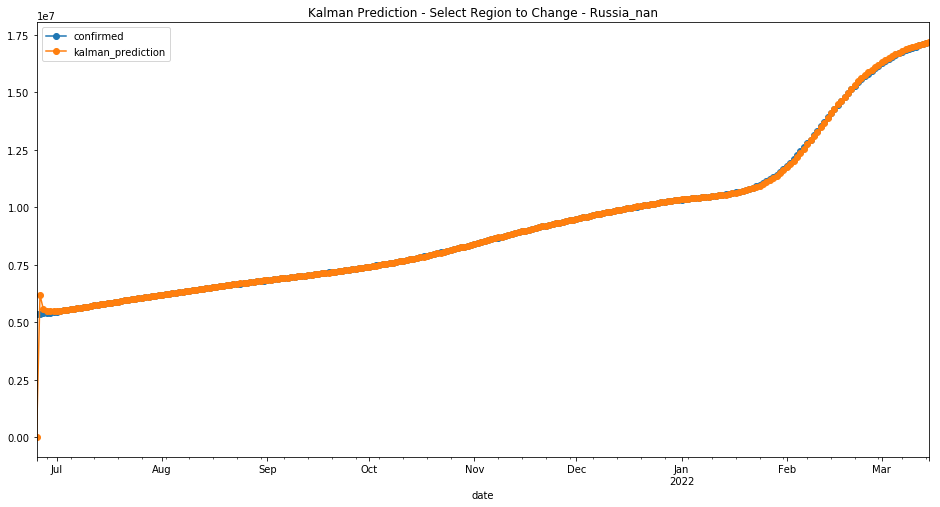

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse           mae
31  Brazil_nan  3.333718e+12  1.825847e+06  149607.34981


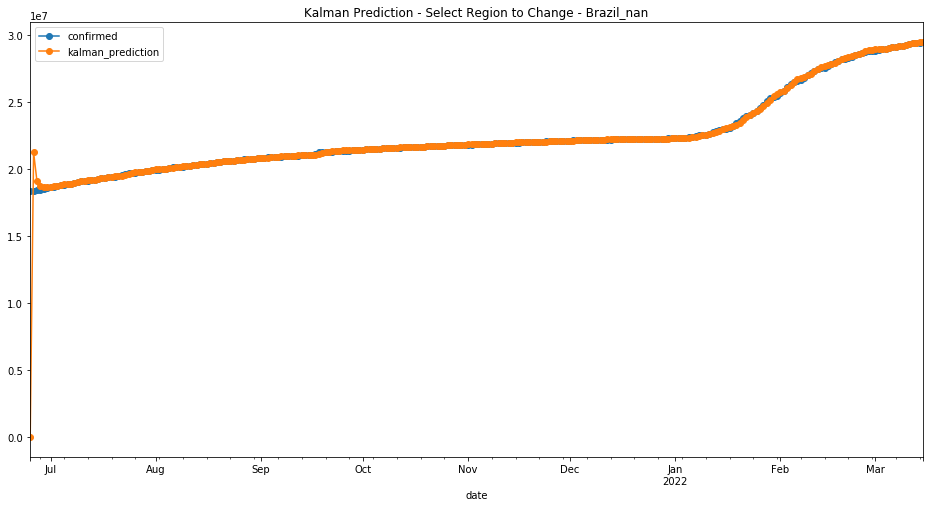

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
272  United Kingdom_nan  1.484838e+12  1.218539e+06  102696.04943


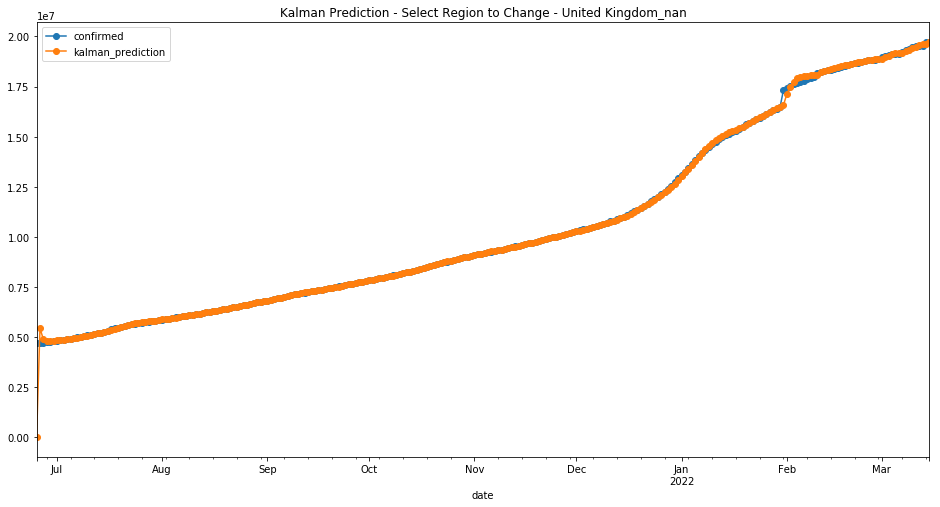

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmqp7qf3p
  JVM stdout: /tmp/tmpmqp7qf3p/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmqp7qf3p/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 4 months and 16 days !!!
H2O cluster name:           H2O_from_python_unknownUser_6luf0z
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-02-16
last_train_date= 2022-03-14
first_bootstrap_date= 2022-03-06
boost_bootstrap_date= 2022-03-11
first_test_date= 2022-03-05
last_test_date= 2022-03-15
first_valid_date= 2022-03-13


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   175905.0     174582 2022-03-06  Afghanistan_nan
1   176110.0     175000 2022-03-07  Afghanistan_nan
2   176496.0     175353 2022-03-08  Afghanistan_nan
3   176871.0     175525 2022-03-09  Afghanistan_nan
4   177115.0     175893 2022-03-10  Afghanistan_nan
5   177493.0     175974 2022-03-11  Afghanistan_nan
6   177609.0     176039 2022-03-12  Afghanistan_nan
7   177703.0     176201 2022-03-13  Afghanistan_nan
8   177826.0     176409 2022-03-14  Afghanistan_nan
9   178007.0          0 2022-03-15  Afghanistan_nan
10  272764.0     272210 2022-03-06      Albania_nan
11  272968.0     272250 2022-03-07      Albania_nan
12  272976.0     272337 2022-03-08      Albania_nan
13  273074.0     272412 2022-03-09      Albania_nan
14  273138.0     272479 2022-03-10      Albania_nan
15  273195.0     272552 2022-03-11      Albania_nan
16  273271.0     272621 2022-03-12      Albania_nan
17  273329.0     272663 2022-03-13      Albania_nan
18  273375.0     272689 2022-03-14      Albania_nan
19  273396.0          0 2022-03-15      Albania_nan
20  266665.0     265265 2022-03-06      Algeria_nan
21  266700.0     265297 2022-03-07      Algeria_nan
22  266728.0     265323 2022-03-08      Algeria_nan
23  266749.0     265346 2022-03-09      Algeria_nan
24  266769.0     265366 2022-03-10      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  3054584.0    3071402 2022-03-11     Austria_nan
176  3106357.0    3115867 2022-03-12     Austria_nan
177  3152879.0    3153927 2022-03-13     Austria_nan
178  3192640.0    3188147 2022-03-14     Austria_nan
179  3227678.0          0 2022-03-15     Austria_nan
180   790208.0     789332 2022-03-06  Azerbaijan_nan
181   790622.0     789481 2022-03-07  Azerbaijan_nan
182   790617.0     789757 2022-03-08  Azerbaijan_nan
183   790847.0     789883 2022-03-09  Azerbaijan_nan
184   790864.0     790153 2022-03-10  Azerbaijan_nan
185   791093.0     790378 2022-03-11  Azerbaijan_nan
186   791242.0     790575 2022-03-12  Azerbaijan_nan
187   791404.0     790767 2022-03-13  Azerbaijan_nan
188   791574.0     790820 2022-03-14  Azerbaijan_nan
189   791580.0          0 2022-03-15  Azerbaijan_nan
190    33997.0      33171 2022-03-06     Bahamas_nan
191    33996.0      33176 2022-03-07     Bahamas_nan
192    33993.0      33180 2022-03-08     Bahamas_nan
193    33998.0      33180 2022-03-09     Bahamas_nan
194    34005.0      33188 2022-03-10     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   55943.0      56124 2022-03-06  Barbados_nan
221   56084.0      56220 2022-03-07  Barbados_nan
222   56185.0      56376 2022-03-08  Barbados_nan
223   56269.0      56551 2022-03-09  Barbados_nan
224   56411.0      56679 2022-03-10  Barbados_nan
225   56583.0      56805 2022-03-11  Barbados_nan
226   56710.0      56922 2022-03-12  Barbados_nan
227   56829.0      57023 2022-03-13  Barbados_nan
228   56939.0      57102 2022-03-14  Barbados_nan
229   57029.0          0 2022-03-15  Barbados_nan
230  932370.0     931002 2022-03-06   Belarus_nan
231  933704.0     932207 2022-03-07   Belarus_nan
232  934541.0     932949 2022-03-08   Belarus_nan
233  934953.0     934187 2022-03-09   Belarus_nan
234  936096.0     935684 2022-03-10   Belarus_nan
235  937414.0     937583 2022-03-11   Belarus_nan
236  939269.0     939514 2022-03-12   Belarus_nan
237  941181.0     941168 2022-03-13   Belarus_nan
238  942877.0     942334 2022-03-14   Belarus_nan
239  944072.0          0 2022-03-15   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  119043259556.44618
# MSE on the validation data =  91937313613601.9
# R^2 on the training data =  0.9989993655175275
# R^2 on the validation data =  0.45057730615698166


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1647333534607_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 119043259556.44618
RMSE: 345026.46211043897
MAE: 25643.25126150562
RMSLE: 0.3374113944735056
Mean Residual Deviance: 119043259556.44618

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 91937313613601.9
RMSE: 9588394.736013005
MAE: 3101739.6147825564
RMSLE: 8.518951537537667
Mean Residual Deviance: 91937313613601.9
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-03-15 08:39:06  0.096 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-03-15 08:39:07  0.776 sec   1.0                703721.6262390986   68702.478463922     495224127236.60156   10239104.512360409  3163113.5234375     104839261215039.3
     2022-03-15 08:39:07  1.023 sec   2.0                560829.3524913952   58324.365564409665  314529562615.9176    10162012.91992676   3142561.7215653155  103266506584758.42
     2022-03-15 08:39:07  1.580 sec   3.0                510898.3335152489   54732.41772274267   261017107188.6585    10134673.369244477  3126755.1490577497  102711604301273.19
     2022-03-15 08:39:07  1.734 sec   4.0                585711.9224215919   55153.34803752171   343058456066.79694   10140719.084295247  3131129.3897881038  102834183546589.81
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-03-15 08:39:34  28.178 sec  277.0              344866.80412037106  27276.37353462395   118933112584.19836   9532793.93003975    3100803.3339027003  90874160112602.7
     2022-03-15 08:39:38  32.631 sec  322.0              344876.03694382624  26744.638783281927  118939480858.07942   9537734.865401782   3101373.3063754416  90968386362700.75
     2022-03-15 08:39:44  37.794 sec  374.0              339888.1571890873   26092.197221578364  115523959397.39372   9562515.787837861   3101927.2076822654  91441708192648.36
     2022-03-15 08:39:50  43.761 sec  436.0              344451.22785889456  25872.202935479818  118646648373.50009   9570255.293300908   3102611.0941151436  91589786378954.05
     2022-03-15 08:39:56  49.774 sec  500.0              345026.46211043897  25643.25126150562   119043259556.44618   9588394.736013005   3101739.6147825564  91937313613601.9


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  1.80931e+20            1                    0.348973
last_day           1.53011e+20            0.845687             0.295122
region             1.12016e+20            0.619106             0.216051
7_day_change       3.2294e+19             0.178488             0.0622873
3_day_change       1.4381e+19             0.0794834            0.0277375
infected_rate      1.19893e+19            0.0662644            0.0231245
1_day_change       7.82869e+18            0.0432688            0.0150996
7_day_change_rate  2.99071e+18            0.0165295            0.00576835
3_day_change_rate  1.80265e+18            0.0099632            0.00347688
1_day_change_rate  1.22367e+18            0.00676316           0.00236016

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.809313e+20           1.000000    0.348973
1           last_day         1.530113e+20           0.845687    0.295122
2             region         1.120157e+20           0.619106    0.216051
3       7_day_change         3.229401e+19           0.178488    0.062287
4       3_day_change         1.438104e+19           0.079483    0.027738
5      infected_rate         1.198930e+19           0.066264    0.023124
6       1_day_change         7.828687e+18           0.043269    0.015100
7  7_day_change_rate         2.990708e+18           0.016530    0.005768
8  3_day_change_rate         1.802654e+18           0.009963    0.003477
9  1_day_change_rate         1.223668e+18           0.006763    0.002360

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


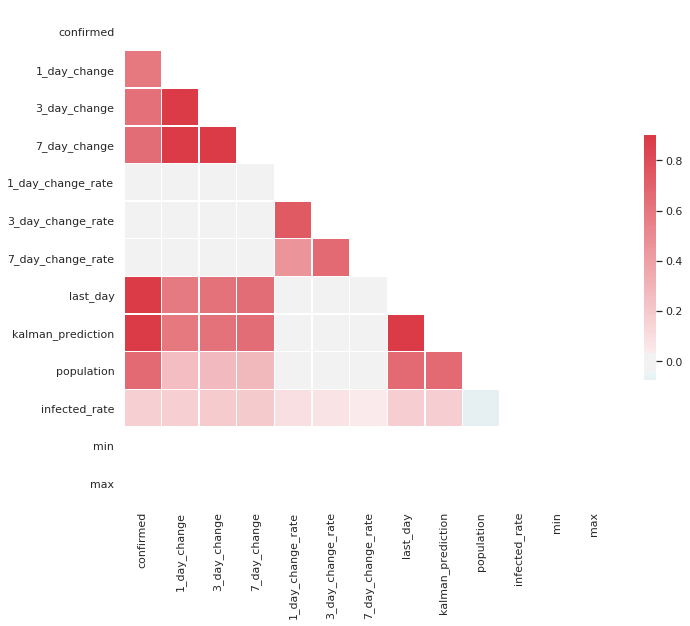

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.589906
3_day_change         0.626535
7_day_change         0.649071
1_day_change_rate    0.021803
3_day_change_rate    0.013126
7_day_change_rate    0.002360
last_day             0.993711
kalman_prediction    0.994688
population           0.665411
infected_rate        0.175410
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


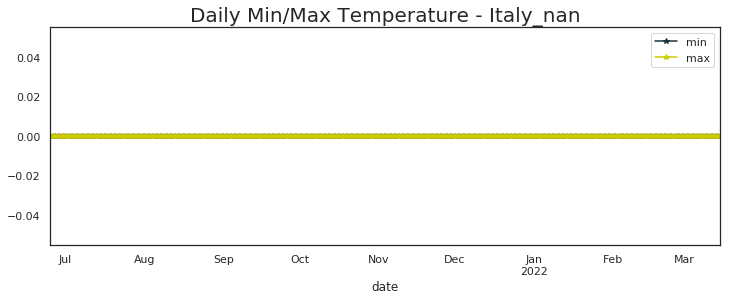

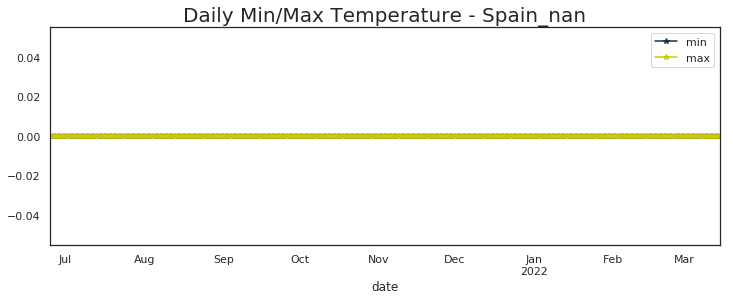

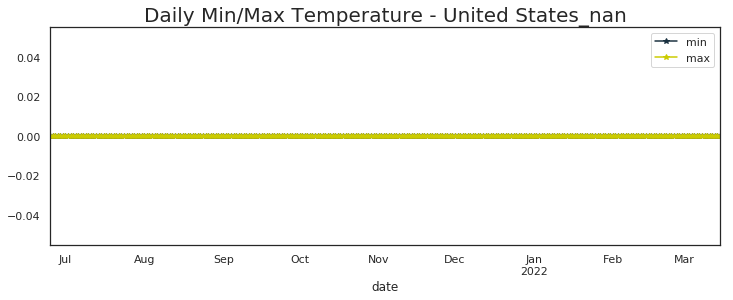

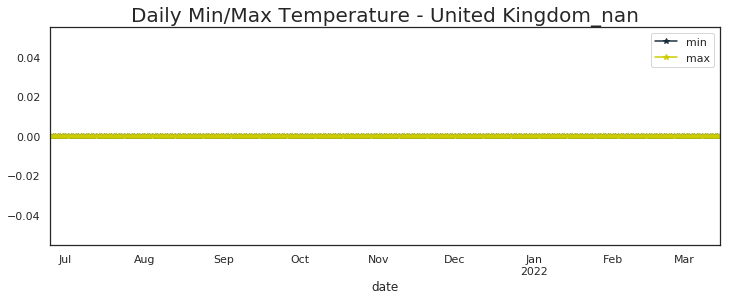

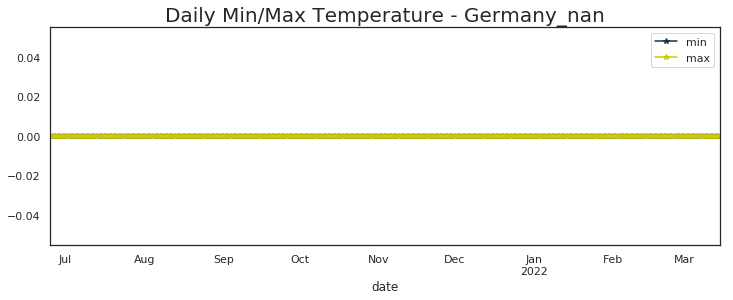

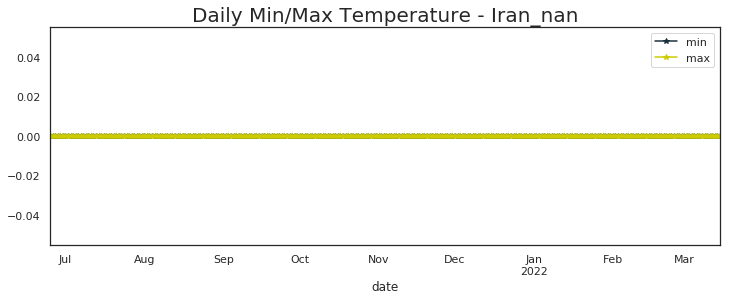

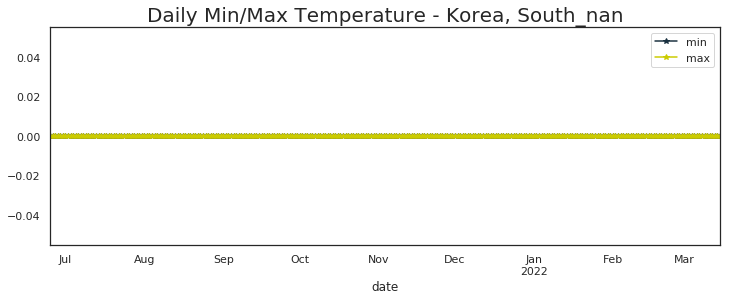

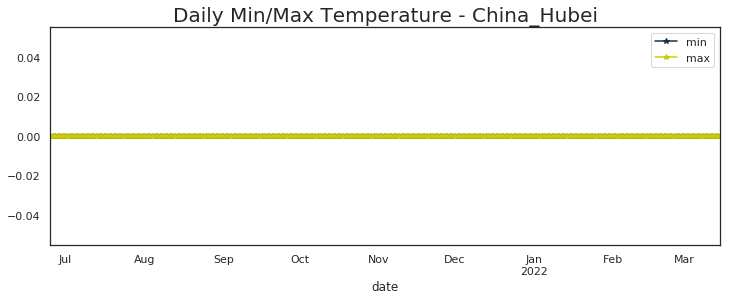

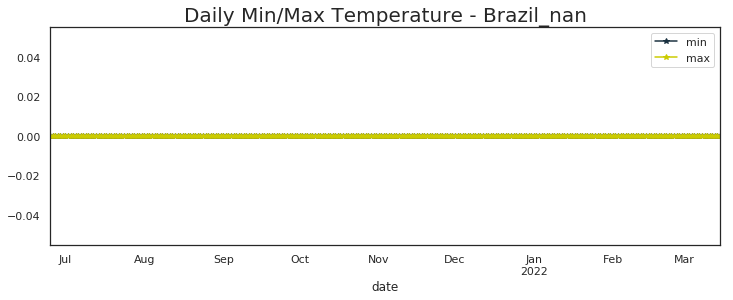

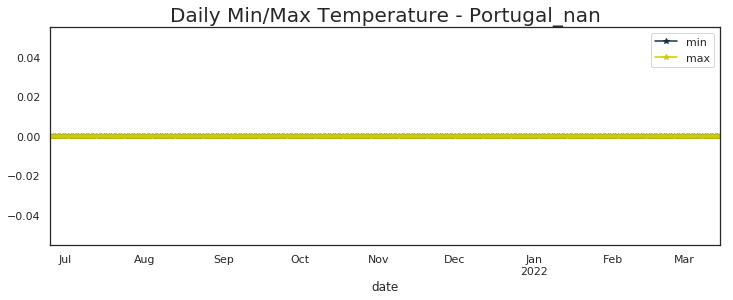

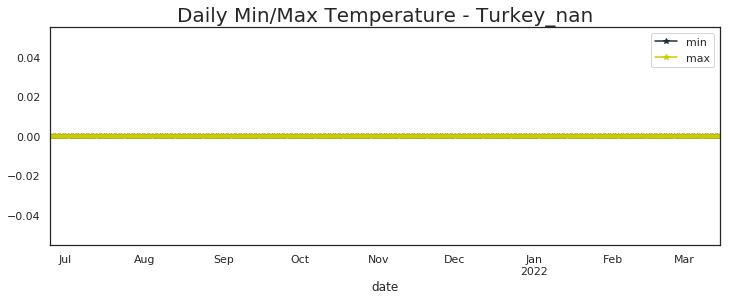

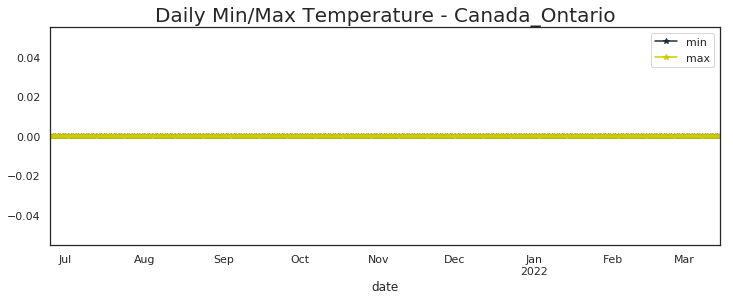

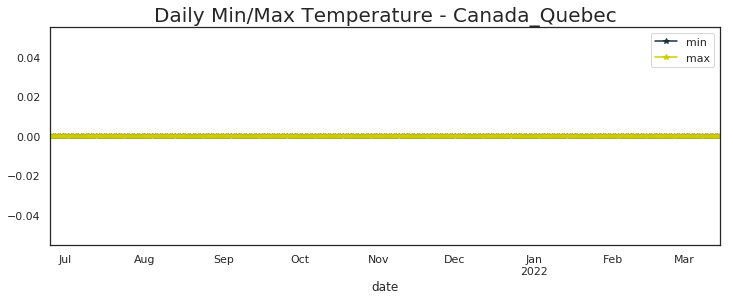

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
France_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Germany_nan                 0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
Italy_nan                   0.0  0.0
Spain_nan                   0.0  0.0
Argentina_nan               0.0  0.0
Netherlands_nan             0.0  0.0
Korea, South_nan            0.0  0.0
Iran_nan                    0.0  0.0
Vietnam_nan                 0.0  0.0
Colombia_nan                0.0  0.0
Indonesia_nan               0.0  0.0
Poland_nan                  0.0  0.0
Japan_nan                   0.0  0.0
Mexico_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
Malaysia_nan                0.0  0.0
Israel_nan                  0.0  0.0
South Africa_nan            0.0  0.0
Cz

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

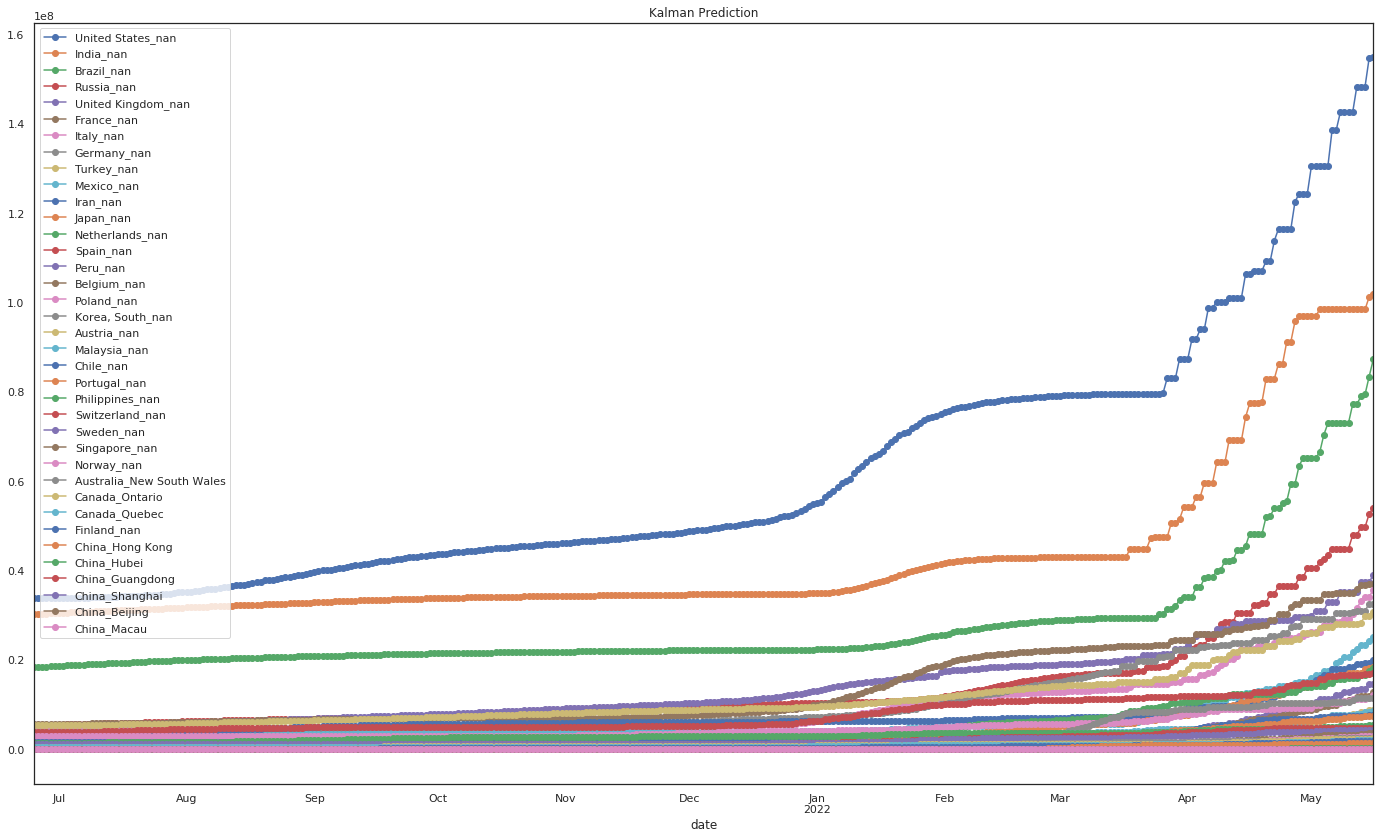

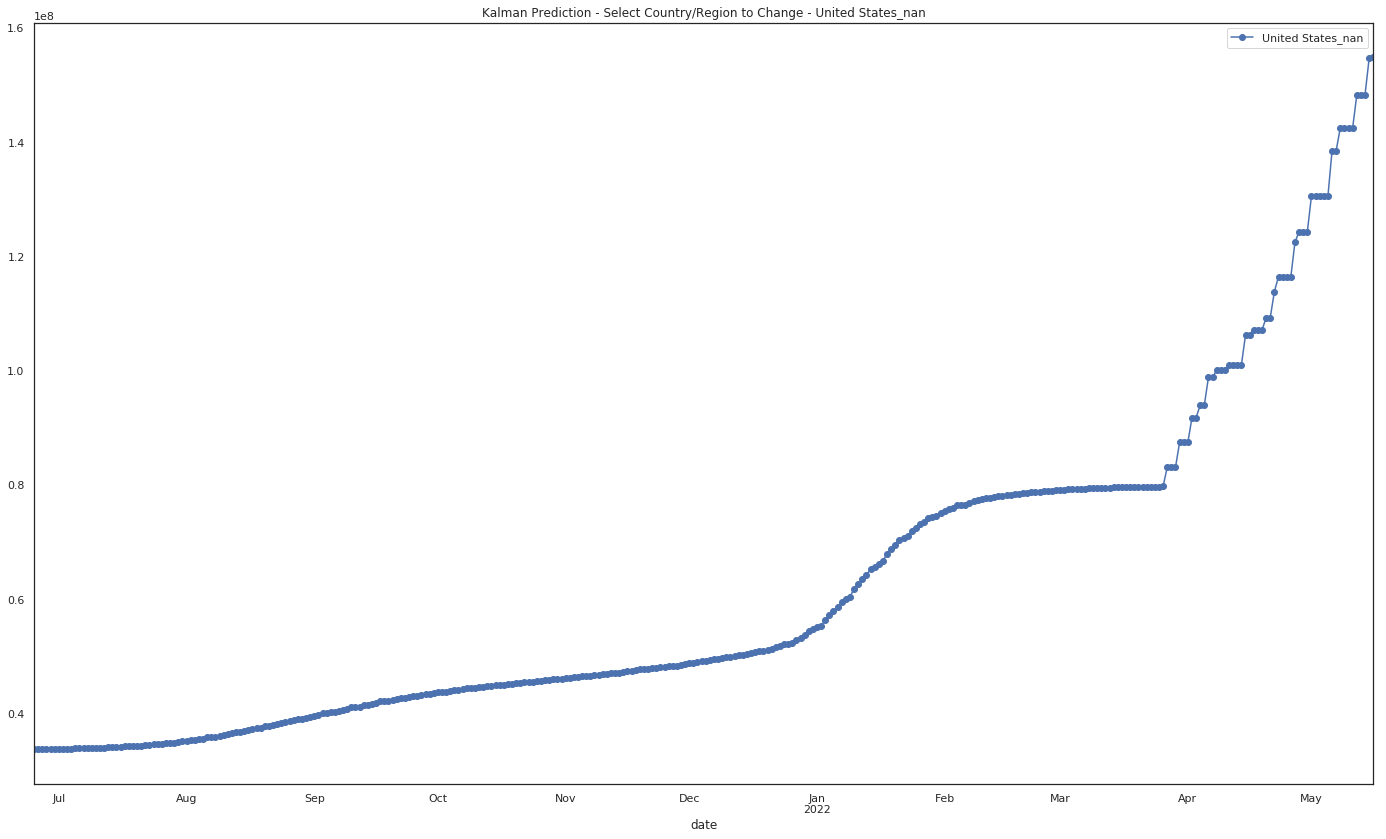

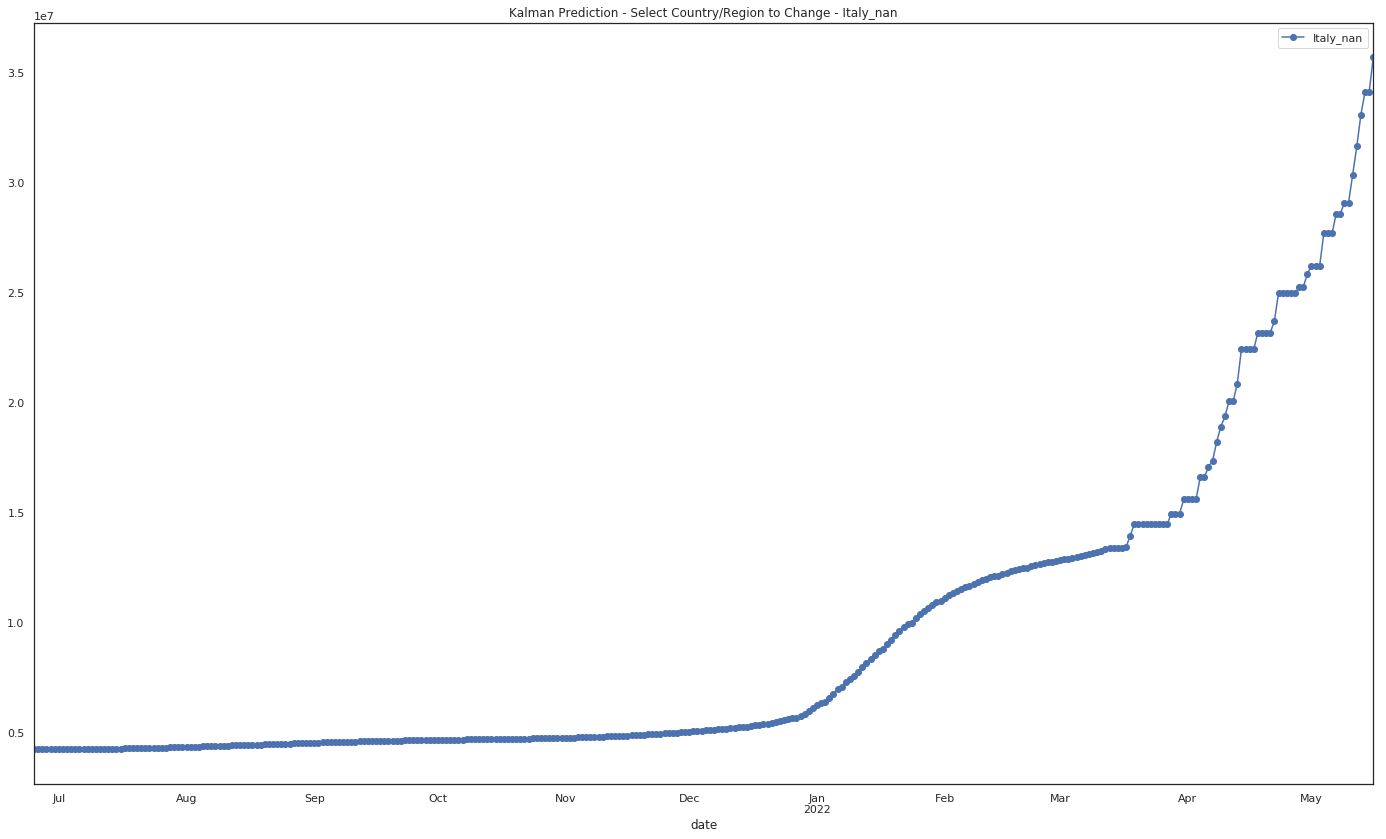

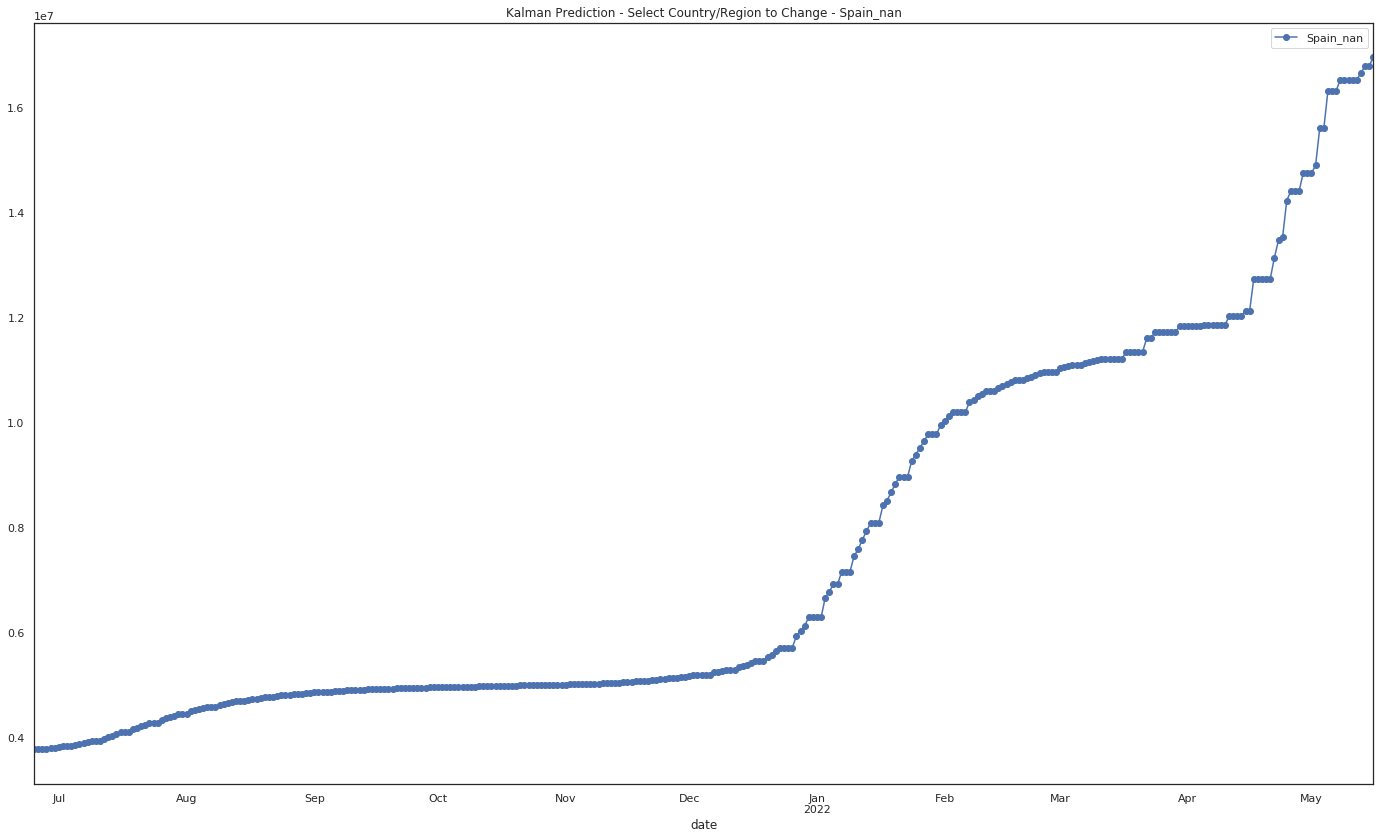

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


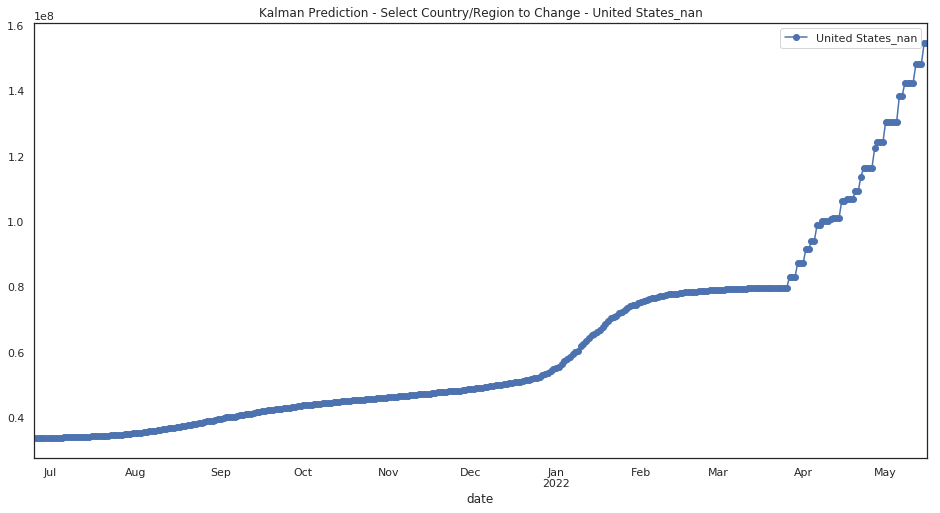

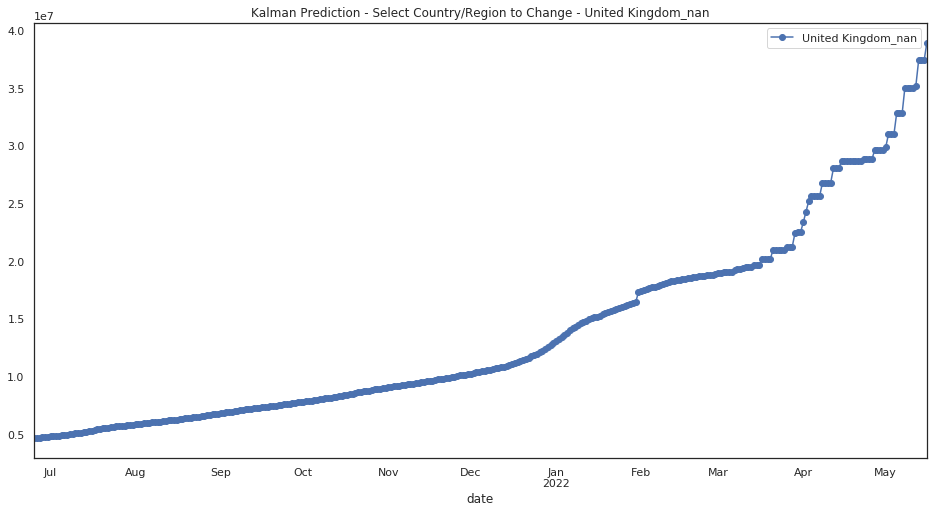

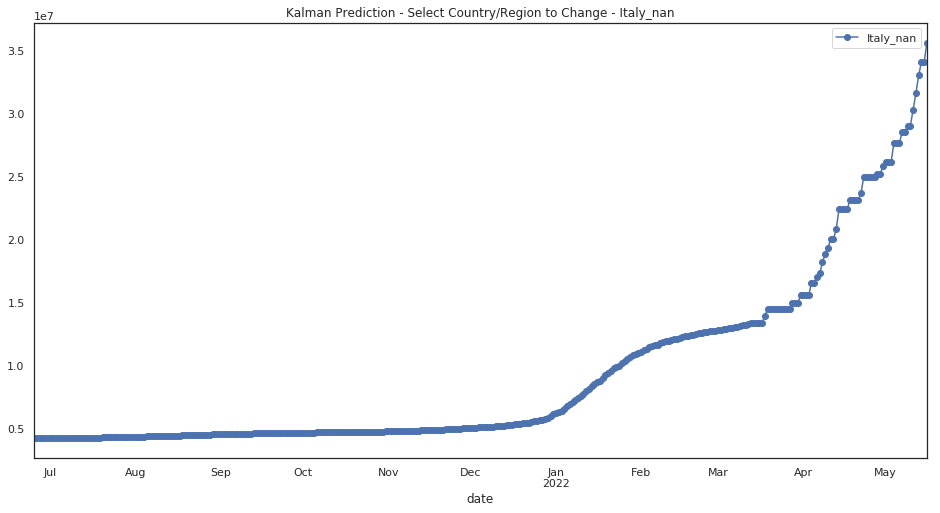

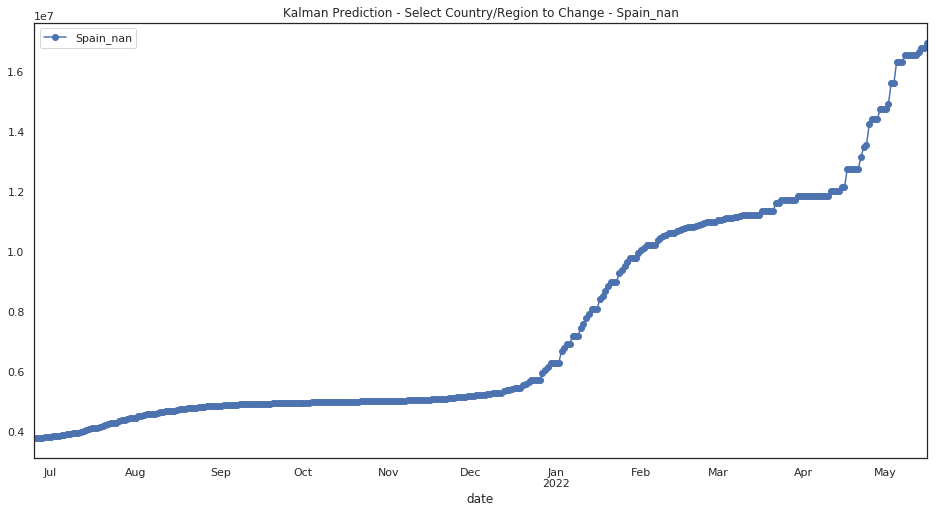

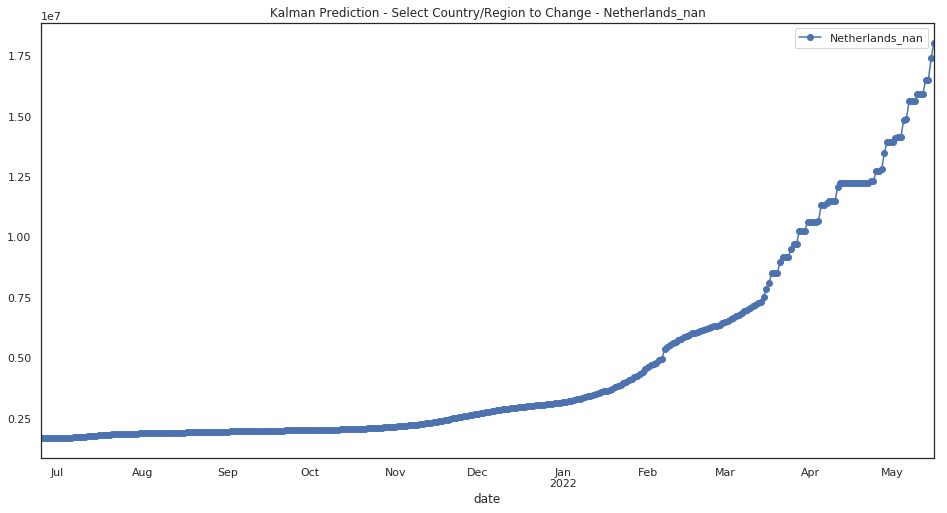

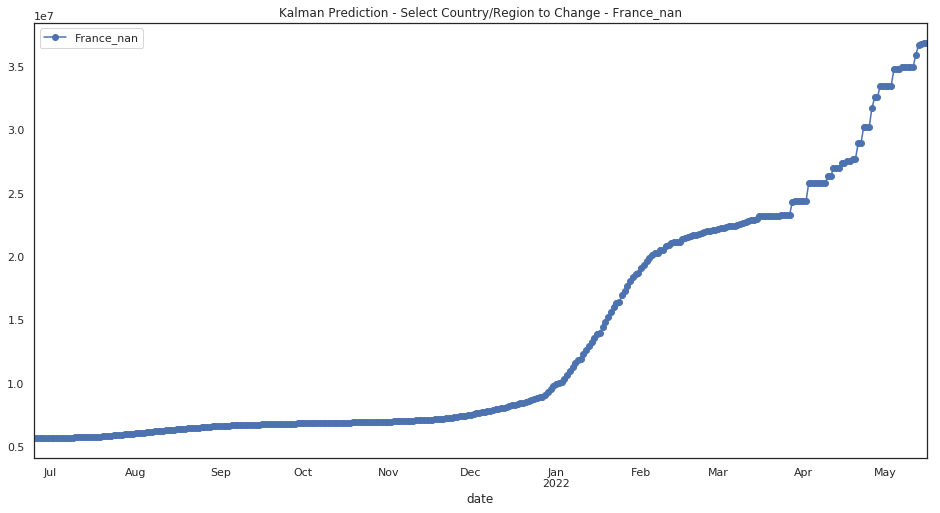

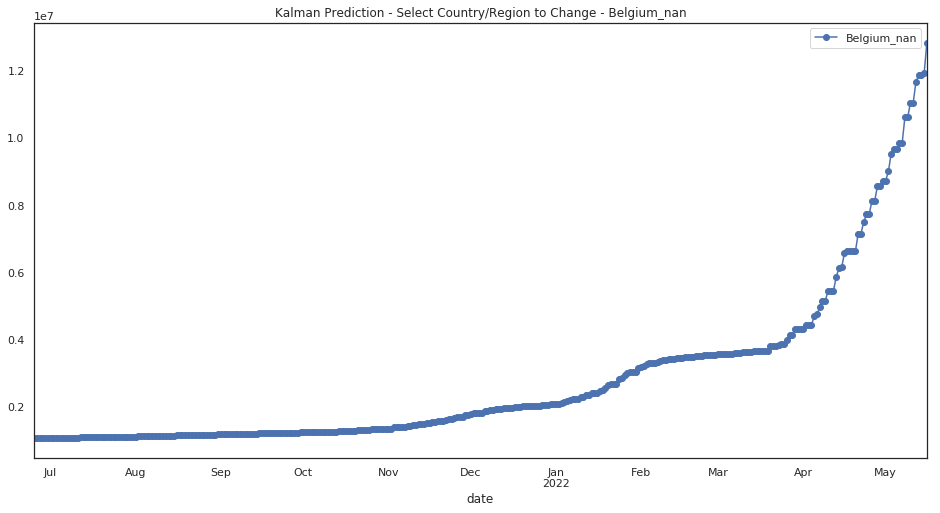

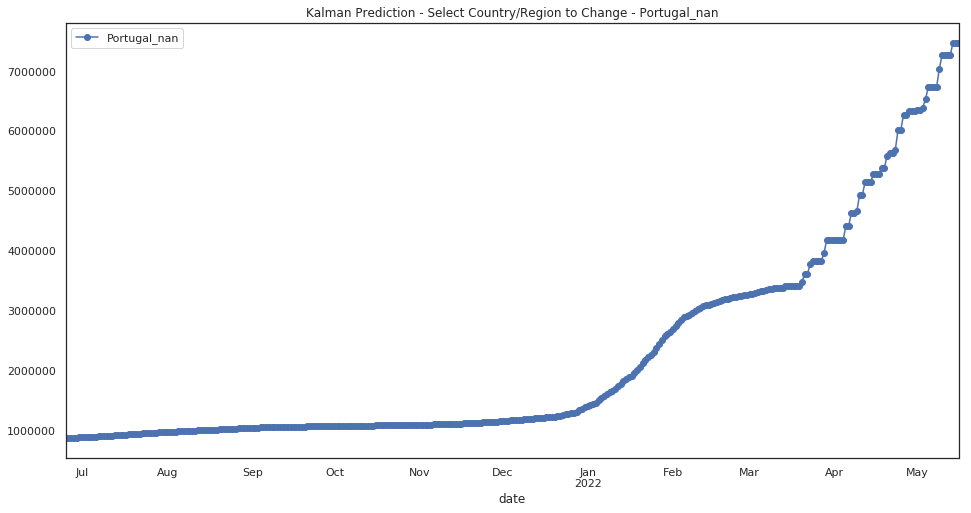

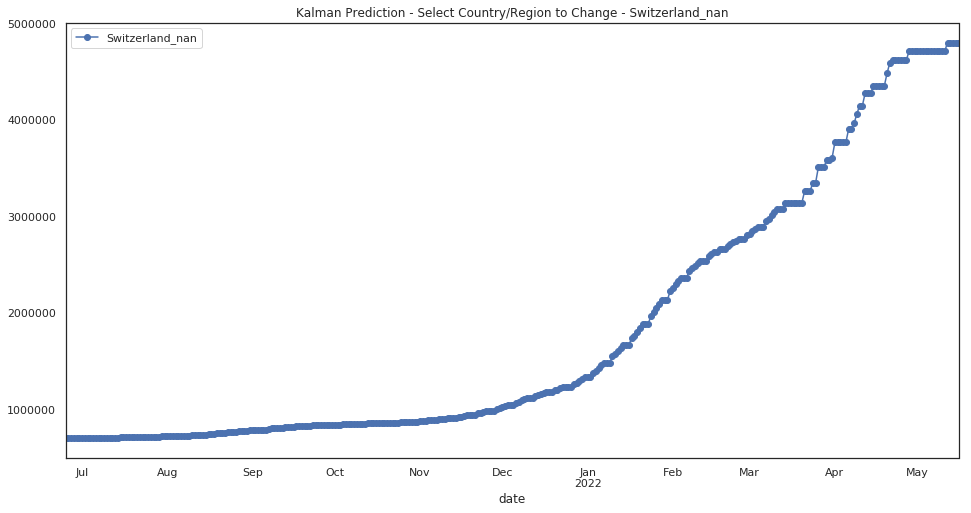

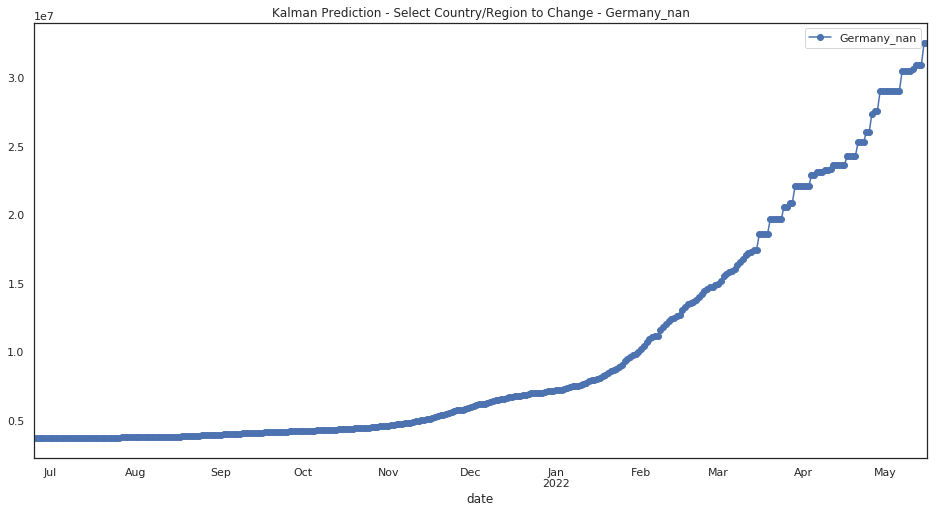

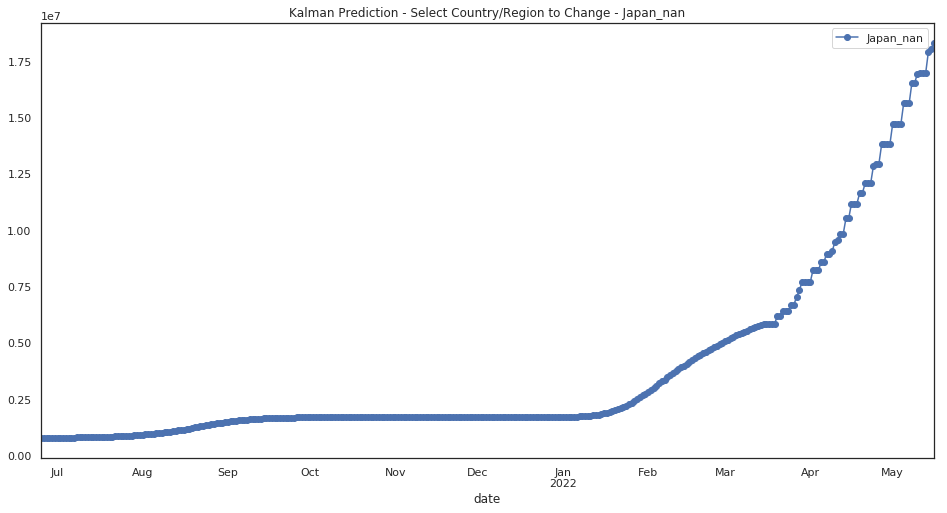

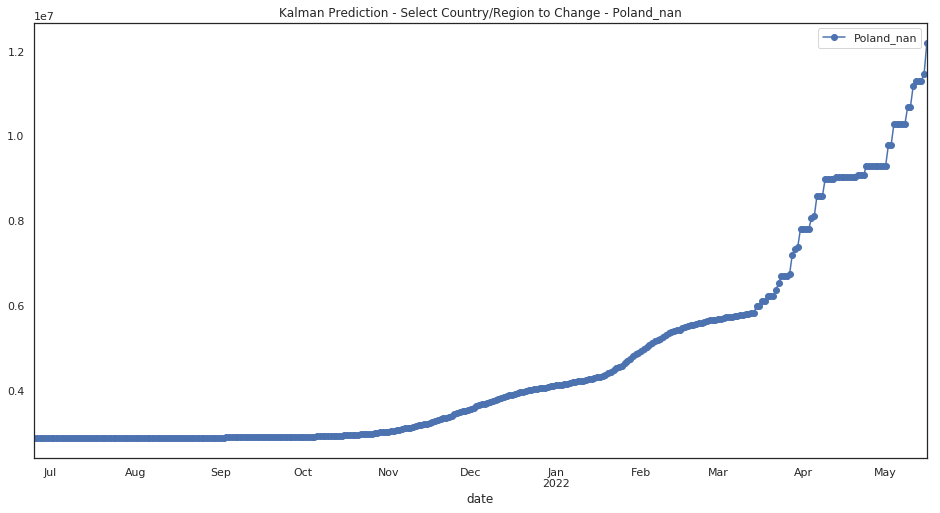

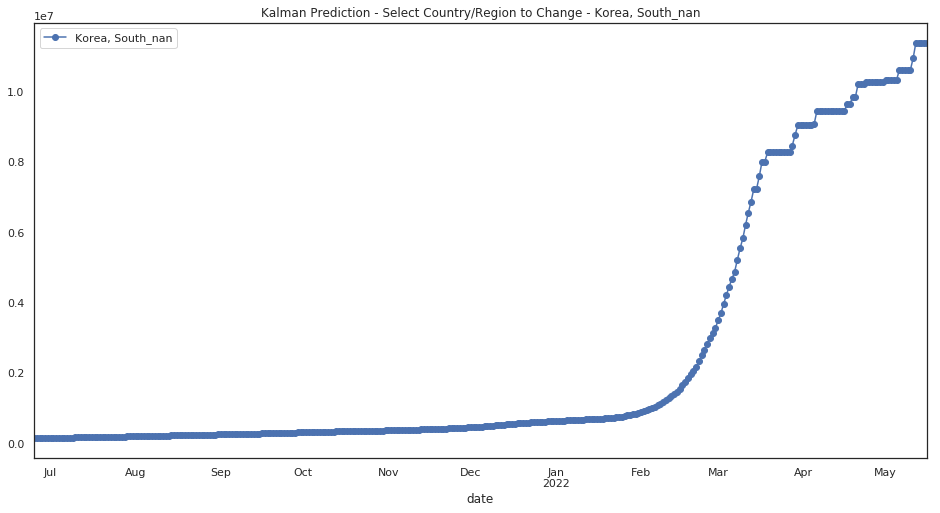

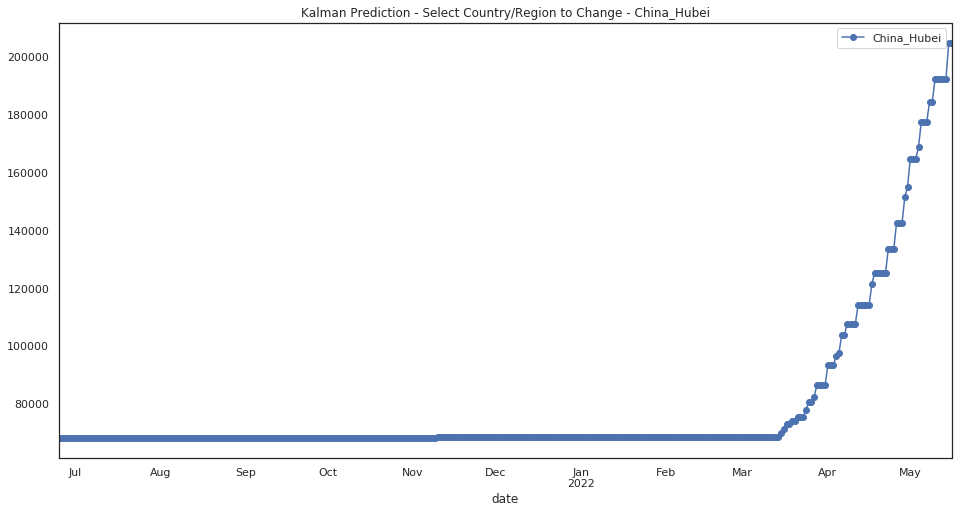

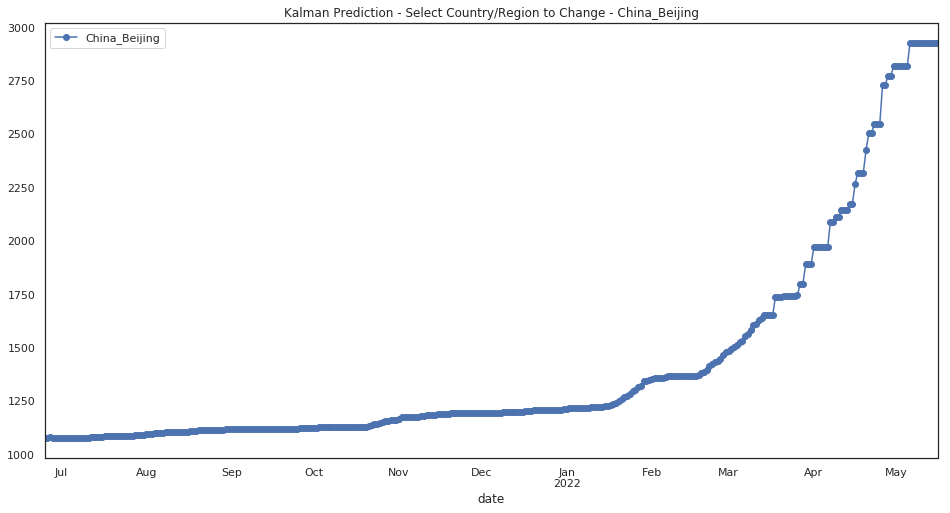

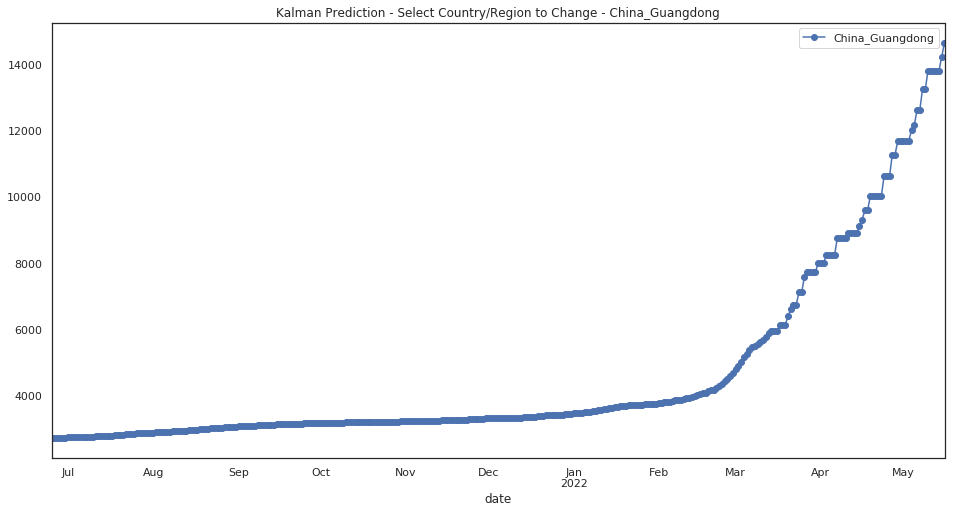

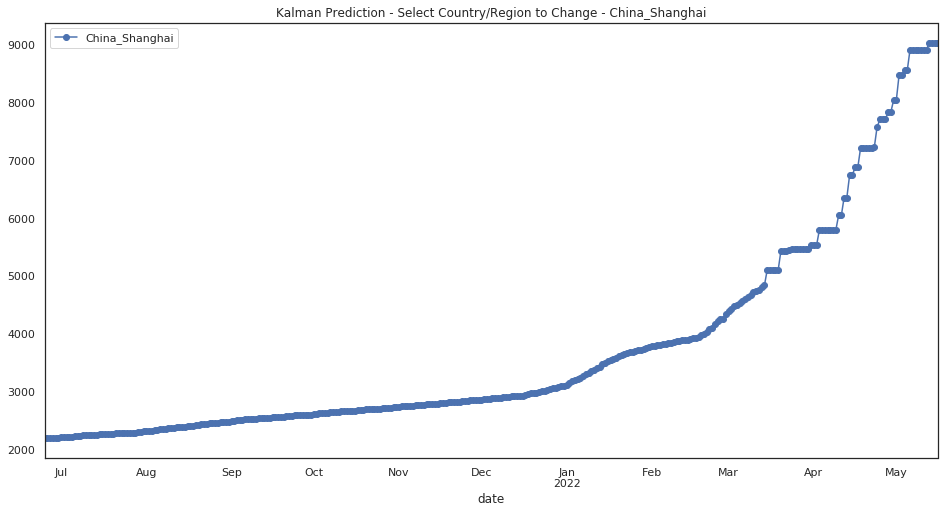

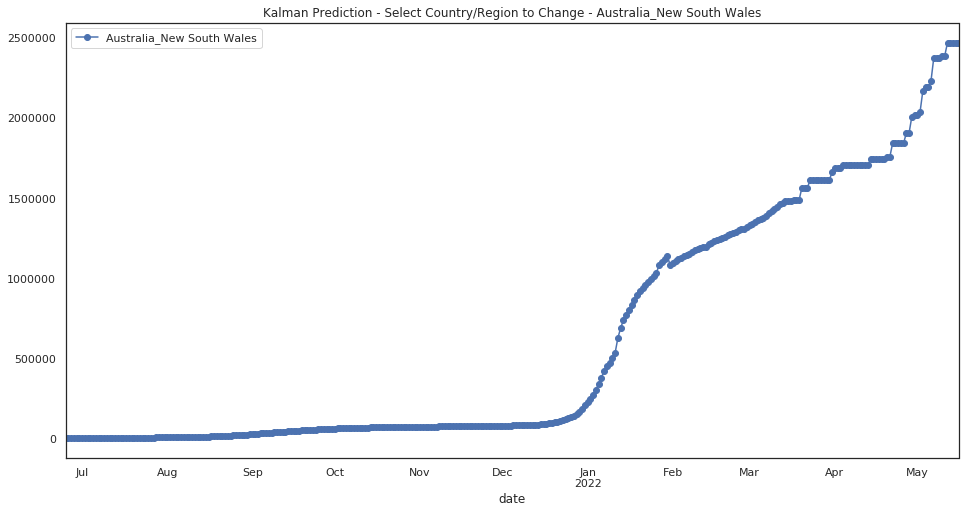

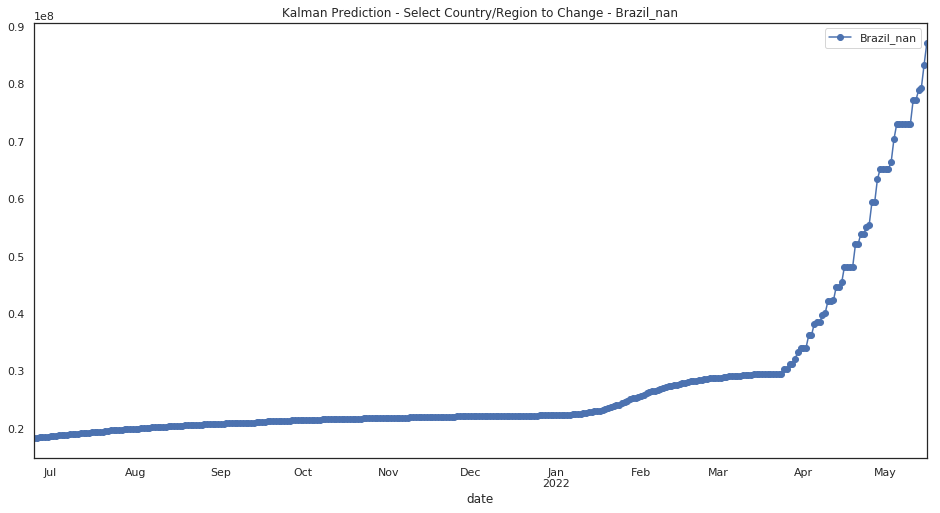

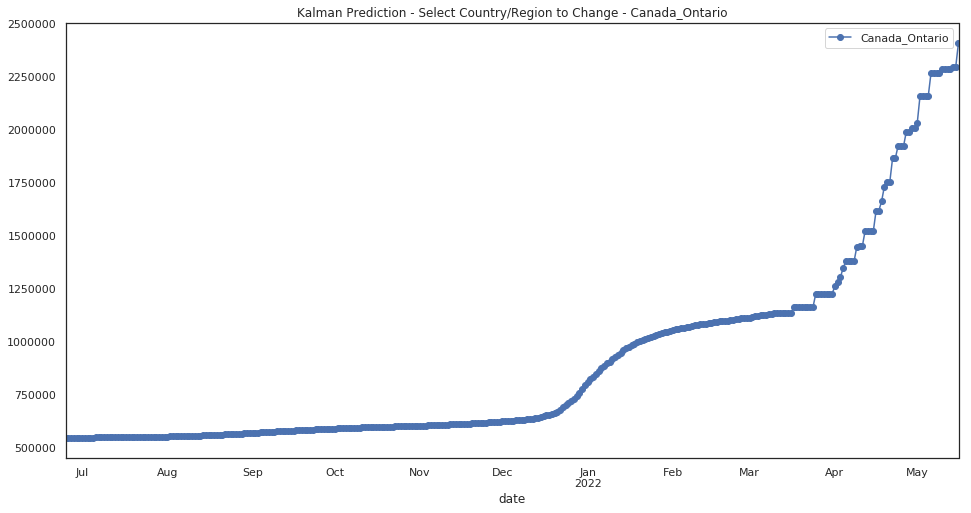

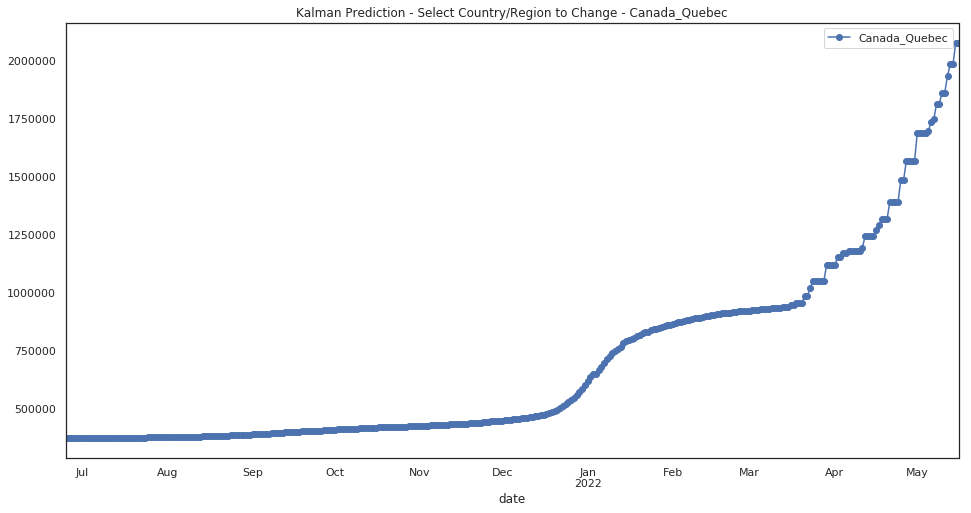

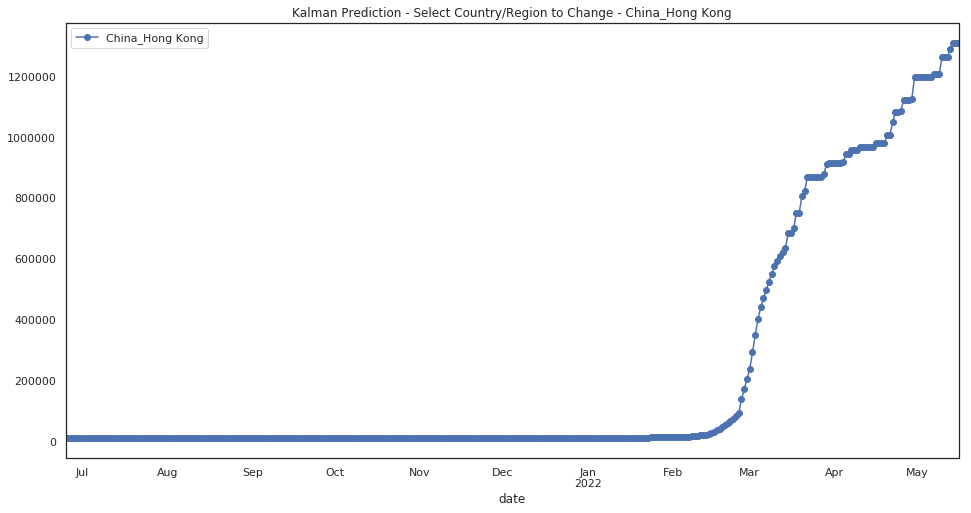

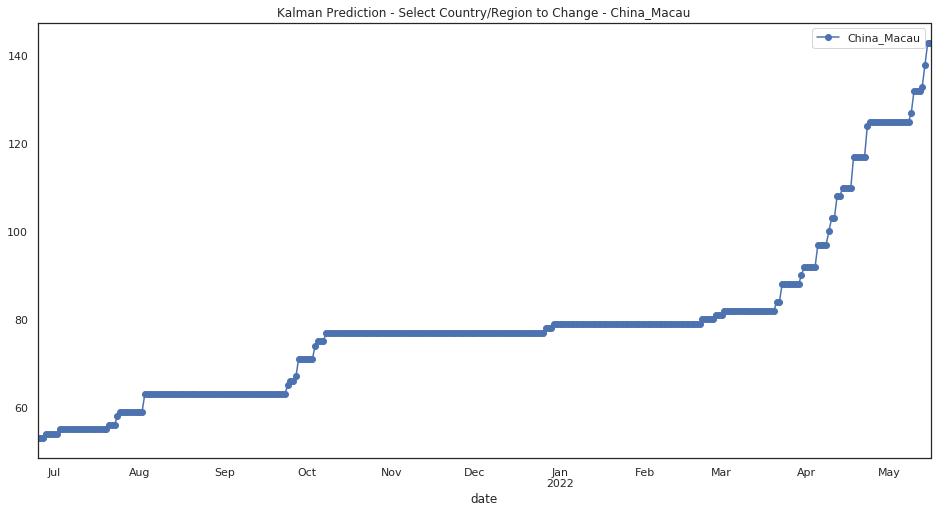

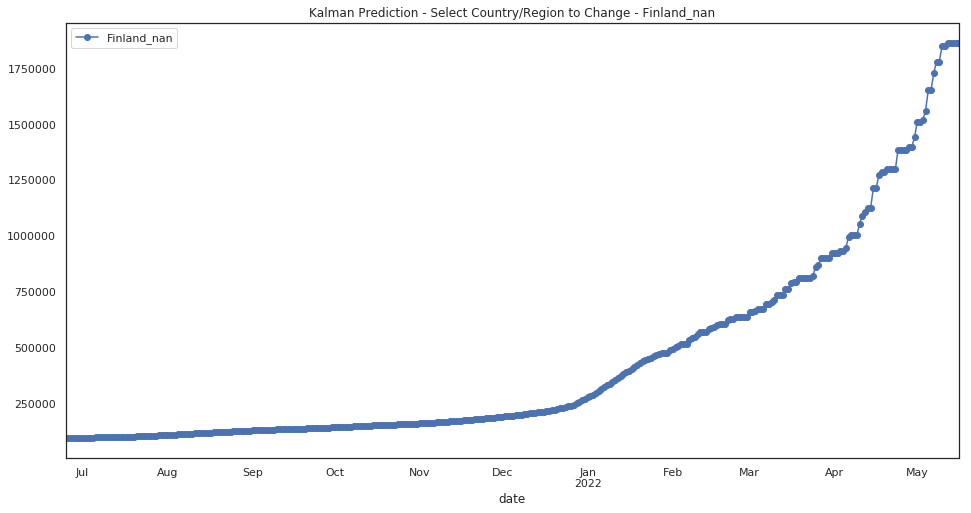

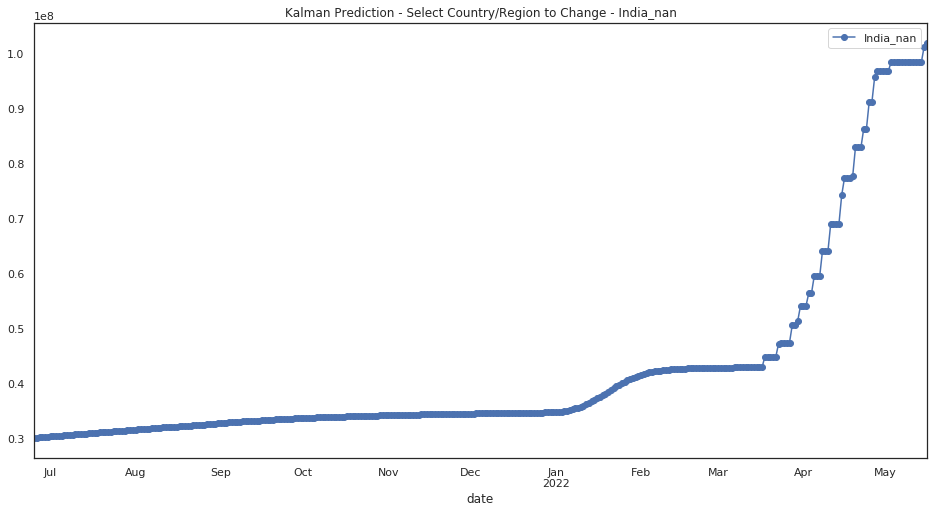

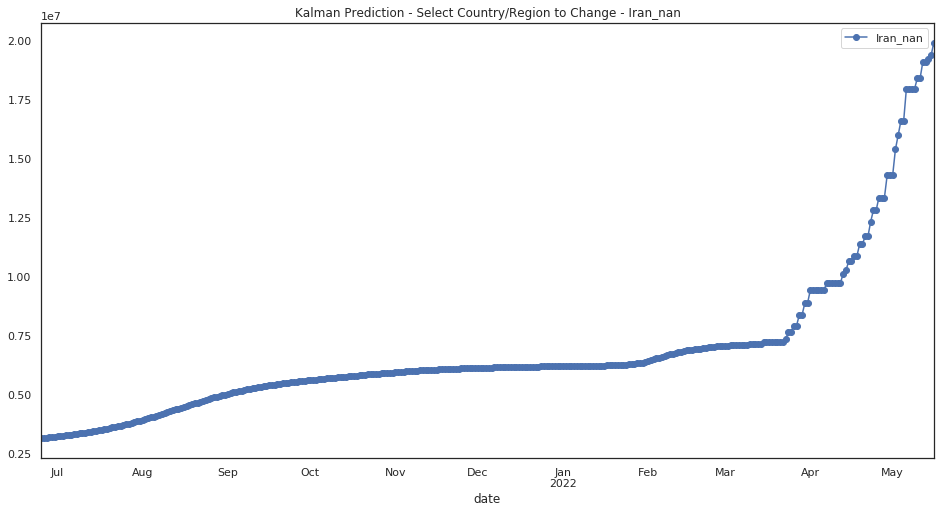

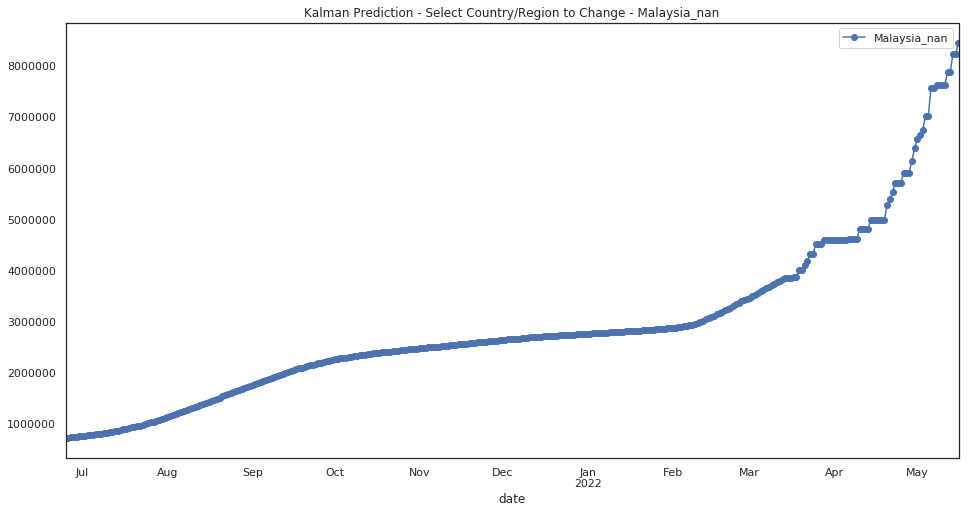

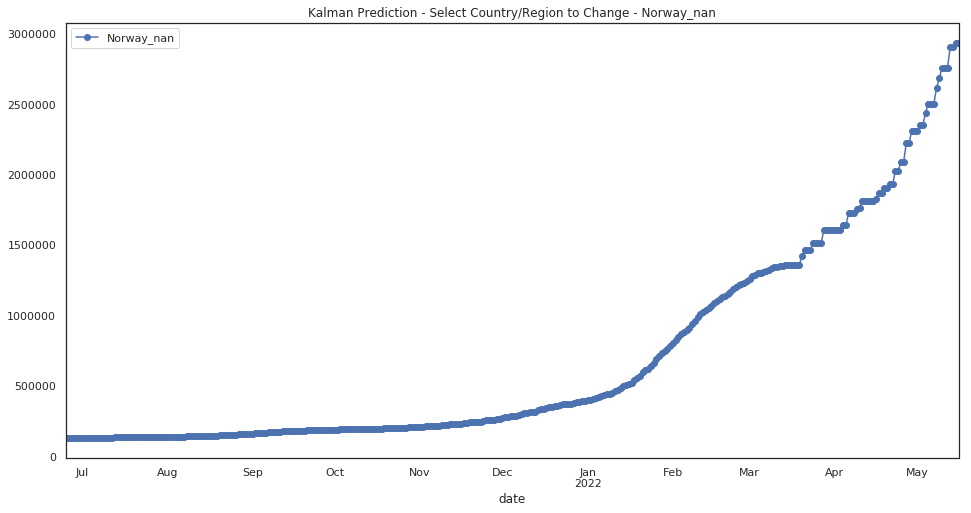

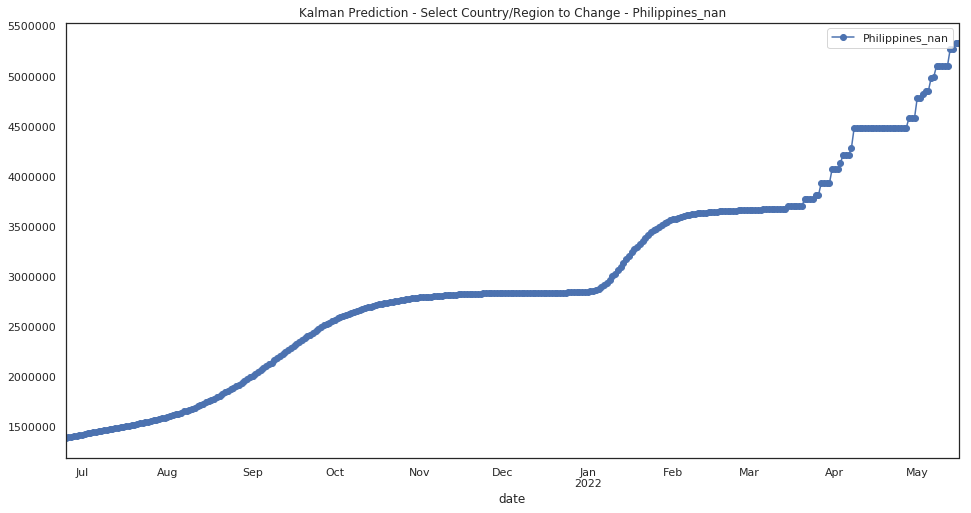

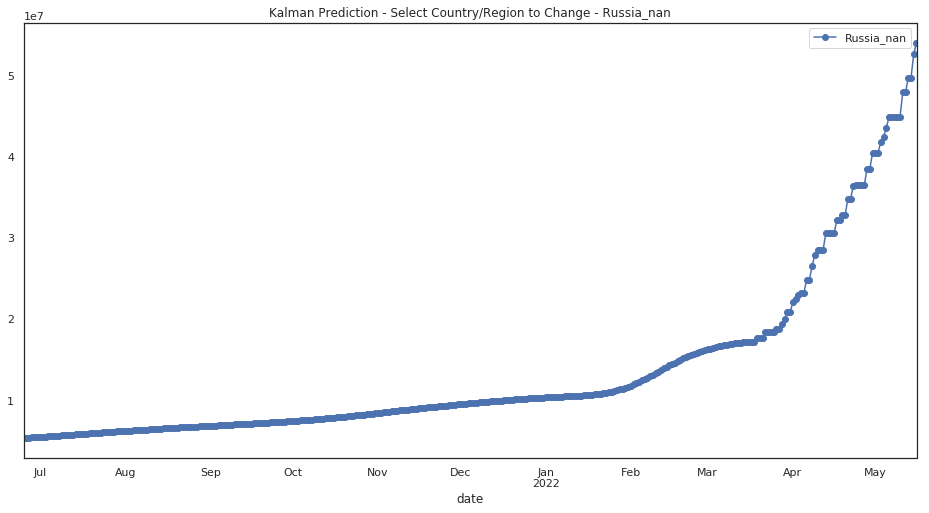

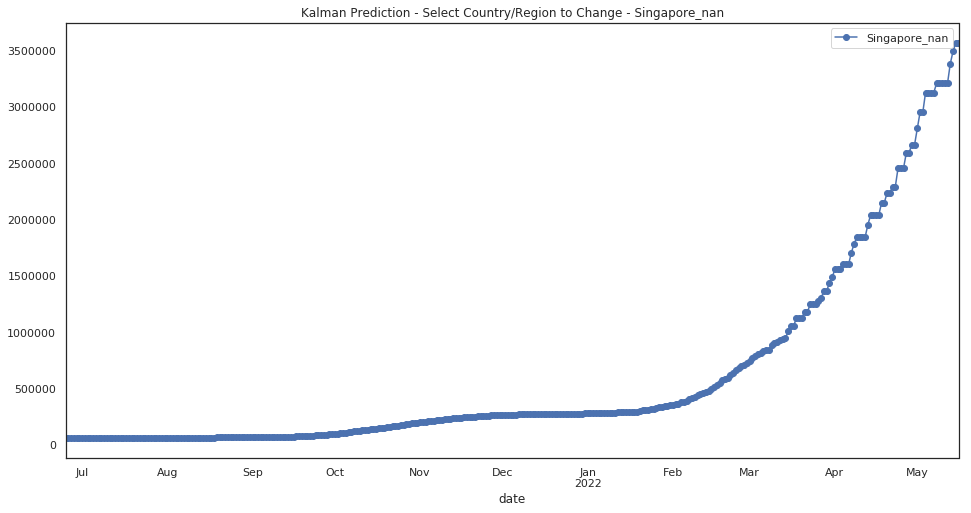

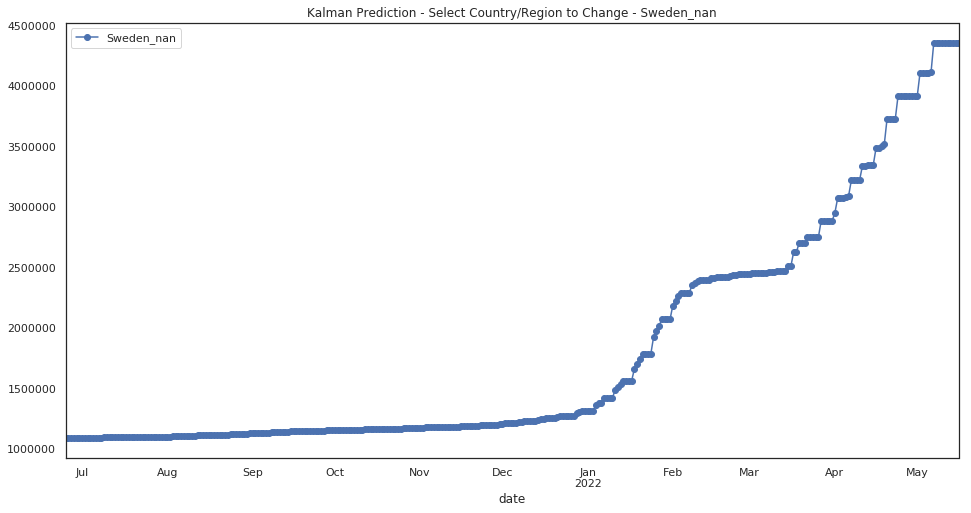

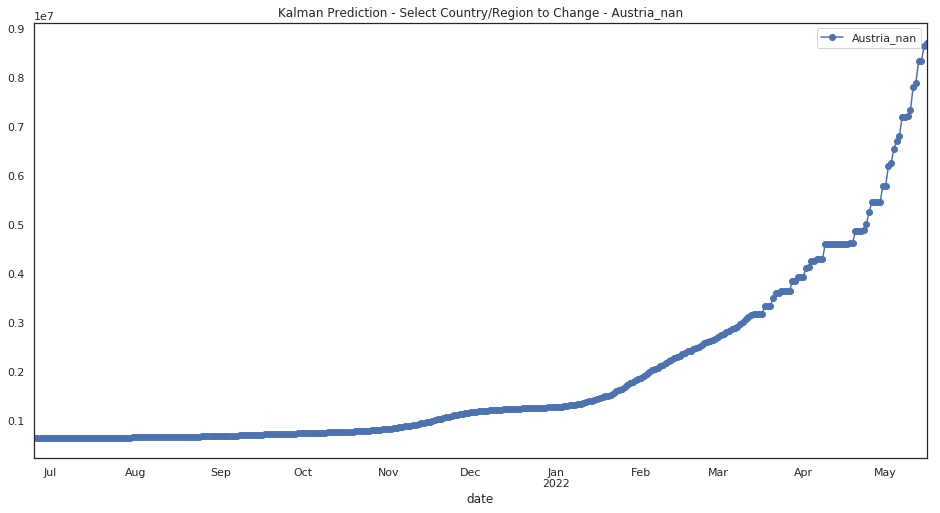

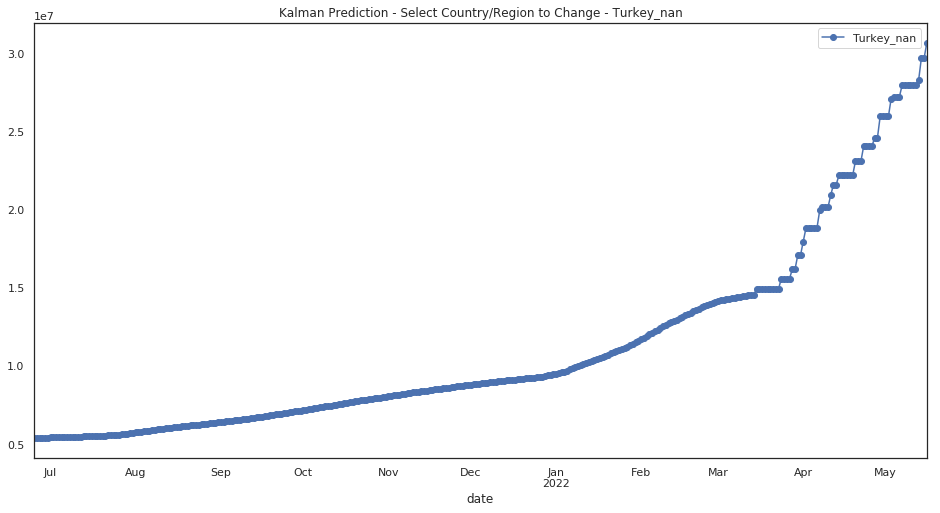

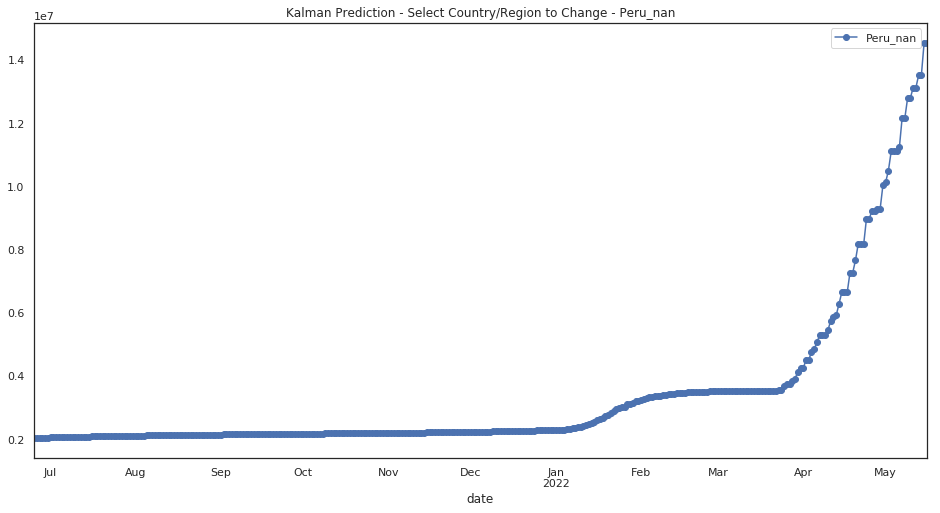

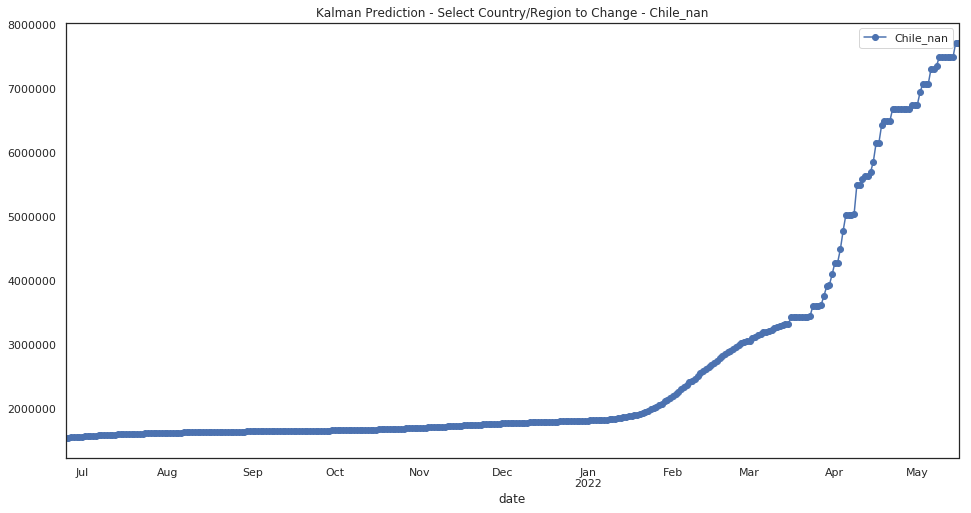

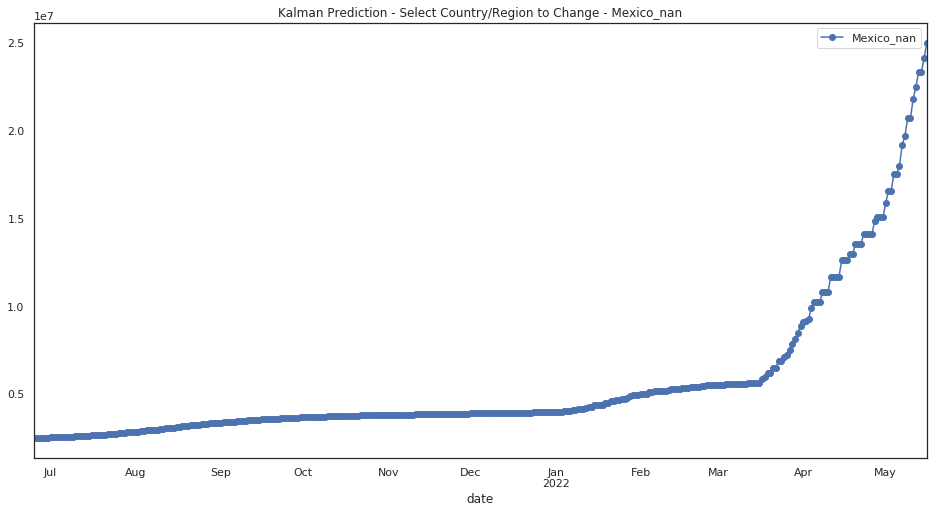

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-05-16 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     154854183.0
India_nan                                           NaN     101956754.0
Brazil_nan                                          NaN      87218481.0
Russia_nan                                          NaN      54031072.0
United Kingdom_nan                                  NaN      38958476.0
France_nan                                          NaN      36889409.0
Italy_nan                                           NaN      35669814.0
Germany_nan                                         NaN      32575788.0
Turkey_nan                                          NaN      30728732.0
Mexico_nan                                          NaN      25010227.0
Argentina_nan                                       NaN      22835798.0
Iran_nan                                            NaN      19917298.0
Japan_nan                                           NaN      18324905.0
Netherlands_nan                                     NaN      18050357.0
Spain_nan                                           NaN      16965894.0
Peru_nan                                            NaN      14548870.0
Colombia_nan                                        NaN      14000992.0
Vietnam_nan                                         NaN      13787017.0
Indonesia_nan                                       NaN      13136304.0
Belgium_nan                                         NaN      12834967.0
Poland_nan                                          NaN      12206531.0
Ukraine_nan                                         NaN      11828221.0
Korea, South_nan                                    NaN      11386189.0
Israel_nan                                          NaN      10046626.0
Austria_nan                                         NaN       8724614.0
South Africa_nan                                    NaN       8524872.0
Malaysia_nan                                        NaN       8457686.0
Slovakia_nan                                        NaN       7756692.0
Chile_nan                                           NaN       7722936.0
Czechia_nan                                         NaN       7680907.0
...                                                 ...             ...
Summer Olympics 2020_nan                            NaN          1942.0
China_Anhui                                         NaN          1908.0
China_Chongqing                                     NaN          1837.0
China_Jiangxi                                       NaN          1684.0
Diamond Princess_nan                                NaN          1492.0
Winter Olympics 2022_nan                            NaN          1116.0
China_Shanxi                                        NaN          1062.0
France_Wallis and Futuna                            NaN           845.0
Vanuatu_nan                                         NaN           655.0
China_Hainan                                        NaN           446.0
United Kingdom_Montserrat                           NaN           382.0
China_Guizhou                                       NaN           296.0
United Kingdom_Falkland Islands (Malvinas)          NaN           273.0
China_Ningxia                                       NaN           258.0
China_Macau                                         NaN           143.0
Samoa_nan                                           NaN           138.0
China_Unknown                                       NaN           105.0
China_Qinghai                                       NaN            59.0
Holy See_nan                                        NaN            55.0
Canada_Grand Princess                               NaN            36.0
Canada_Repatriated Travellers                       NaN            28.0
Antarctica_nan                                      NaN            12.0
MS Zaandam_nan                                      NaN             9.0
Marshall Islands_nan                                NaN             7.0
United Kingdom_Saint H

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-06-25         164605.0     182564.0     187086.0      80699.0   
2021-06-26         165920.0     182567.0     187379.0      80699.0   
2021-06-27         113124.0     132509.0     138113.0      13882.0   
2021-06-28         114220.0     132512.0     138465.0      13882.0   
2021-06-29         116698.0     132513.0     138840.0      13882.0   
2021-06-30         118189.0     132514.0     139229.0      13900.0   
2021-07-01         119776.0     132521.0     139626.0      13911.0   
2021-07-02         121673.0     132523.0     140075.0      13918.0   
2021-07-03         124478.0     133634.0     142349.0      13951.0   
2021-07-04         125757.0     133636.0     142807.0      13948.0   
2021-07-05         126928.0     133637.0     143293.0      13946.0   
2021-07-06         128374.0     133644.0     143772.0      14009.0   
2021-07-07         129946.0     133656.0     144337.0      13991.0   
2021-07-08         131129.0     133665.0     144959.0      14021.0   
2021-07-09         132557.0     133679.0     145761.0      14050.0   
2021-07-10         133833.0     133687.0     146600.0      14075.0   
2021-07-11         134662.0     133691.0     147366.0      14108.0   
2021-07-12         135687.0     133696.0     148216.0      14169.0   
2021-07-13         136896.0     133705.0     149139.0      14155.0   
2021-07-14         137752.0     133714.0     150044.0      14167.0   
2021-07-15         138915.0     133726.0     151112.0      14261.0   
2021-07-16         140150.0     133744.0     152305.0      14239.0   
2021-07-17         141344.0     133763.0     153431.0      14273.0   
2021-07-18         141866.0     133783.0     154517.0      14301.0   
2021-07-19         142592.0     133795.0     155662.0      14356.0   
2021-07-20         143541.0     133832.0     156934.0      14359.0   
2021-07-21         143974.0     133860.0     158174.0      14379.0   
2021-07-22         144357.0     133890.0     159364.0      14469.0   
2021-07-23         144661.0     133922.0     160690.0      14464.0   
2021-07-24         144891.0     133946.0     162017.0      14498.0   
...                     ...          ...          ...          ...   
2022-04-18         237549.0     420548.0     437792.0      56236.0   
2022-04-19         238234.0     431930.0     437792.0      56236.0   
2022-04-20         241916.0     444151.0     437792.0      56277.0   
2022-04-21         256206.0     439850.0     437792.0      56277.0   
2022-04-22         265652.0     438981.0     437792.0      57112.0   
2022-04-23         264497.0     441122.0     437792.0      58501.0   
2022-04-24         262954.0     443005.0     437792.0      60165.0   
2022-04-25         270774.0     442726.0     437792.0      60165.0   
2022-04-26         275094.0     442726.0     445062.0      62277.0   
2022-04-27         277630.0     457923.0     449790.0      62277.0   
2022-04-28         281202.0     468380.0     456875.0      62277.0   
2022-04-29         288408.0     460969.0     463935.0      62277.0   
2022-04-30         293907.0     463733.0     457924.0      63918.0   
2022-05-01         289823.0     465244.0     457924.0      63918.0   
2022-05-02         289823.0     464915.0     476259.0      63918.0   
2022-05-03         294682.0     467109.0     499746.0      64787.0   
2022-05-04         297352.0     469284.0     497814.0      64787.0   
2022-05-05         305890.0     469140.0     492449.0      65888.0   
2022-05-06         311553.0     470764.0     492449.0      66156.0   
2022-05-07         307808.0     471858.0     492449.0      66950.0   
2022-05-08         316108.0     471476.0     503661.0      66950.0   
2022-05-09         320474.0     471476.0     512106.0      66950.0   
2022-05-10         326617.0     484703.0     507103.0      69586.0   
2022-05-11         344949.0     494088.0     508032.0      69586.0   
2022-05-12

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'United Kingdom_nan',
 'France_nan',
 'Italy_nan',
 'Germany_nan',
 'Turkey_nan',
 'Mexico_nan',
 'Argentina_nan',
 'Iran_nan',
 'Japan_nan',
 'Netherlands_nan',
 'Spain_nan',
 'Peru_nan',
 'Colombia_nan',
 'Vietnam_nan',
 'Indonesia_nan',
 'Belgium_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Korea, South_nan',
 'Israel_nan',
 'Austria_nan',
 'South Africa_nan',
 'Malaysia_nan',
 'Slovakia_nan',
 'Chile_nan',
 'Czechia_nan',
 'Portugal_nan',
 'Thailand_nan',
 'Romania_nan',
 'Philippines_nan',
 'Denmark_nan',
 'Serbia_nan',
 'Switzerland_nan',
 'Sweden_nan',
 'Greece_nan',
 'Jordan_nan',
 'Georgia_nan',
 'Morocco_nan',
 'Hungary_nan',
 'Singapore_nan',
 'Bangladesh_nan',
 'Iraq_nan',
 'Pakistan_nan',
 'Norway_nan',
 'Latvia_nan',
 'Croatia_nan',
 'Kazakhstan_nan',
 'Australia_Victoria',
 'Bulgaria_nan',
 'Australia_New South Wales',
 'New Zealand_nan',
 'Canada_Ontario',
 'Cuba_nan',
 'Ireland_nan',
 'United Arab Emirates_na

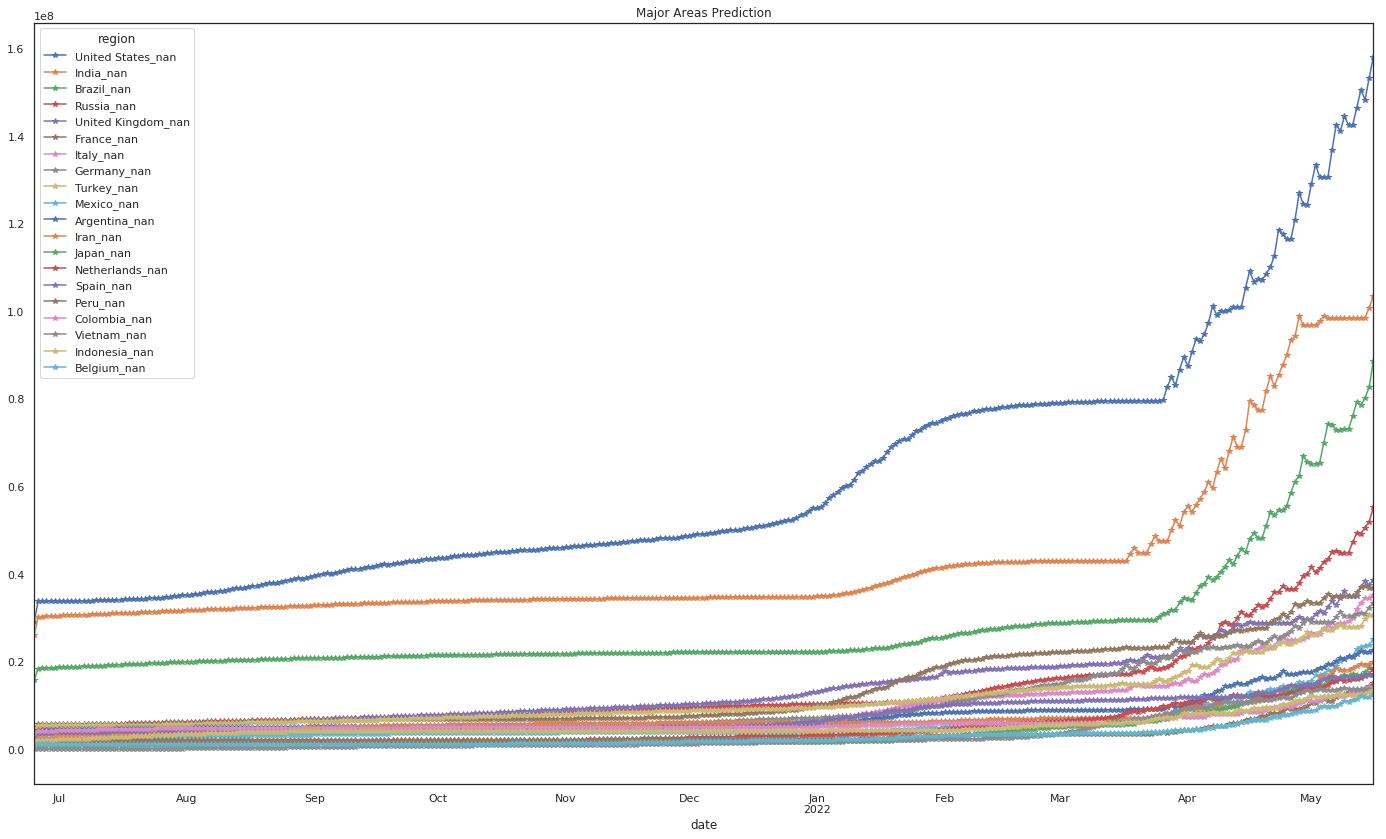

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

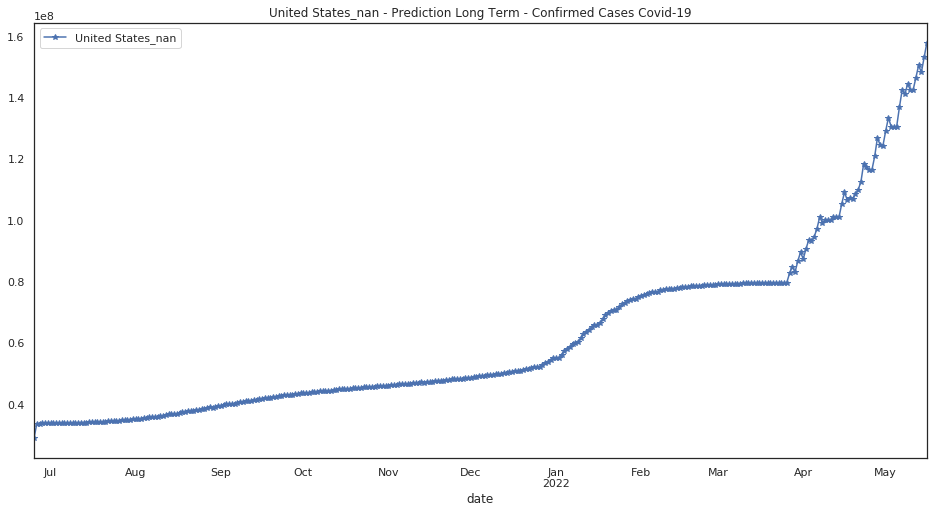

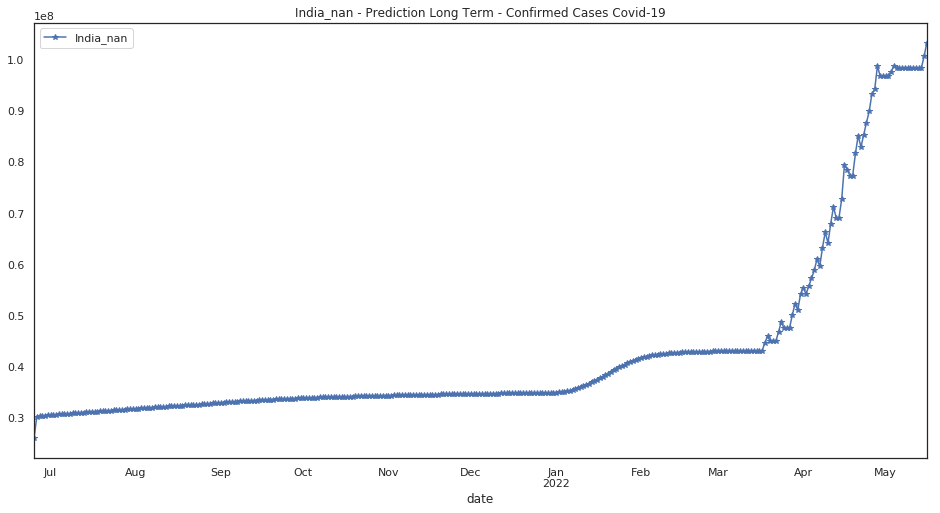

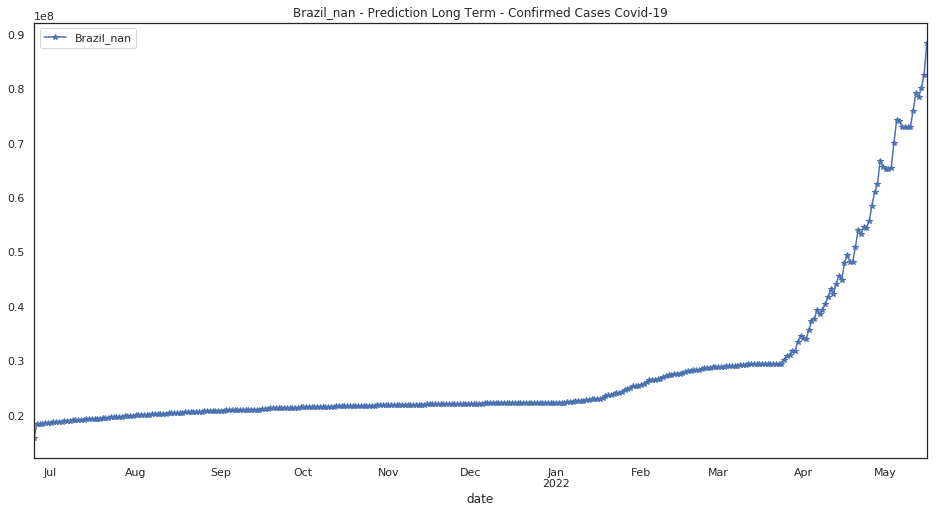

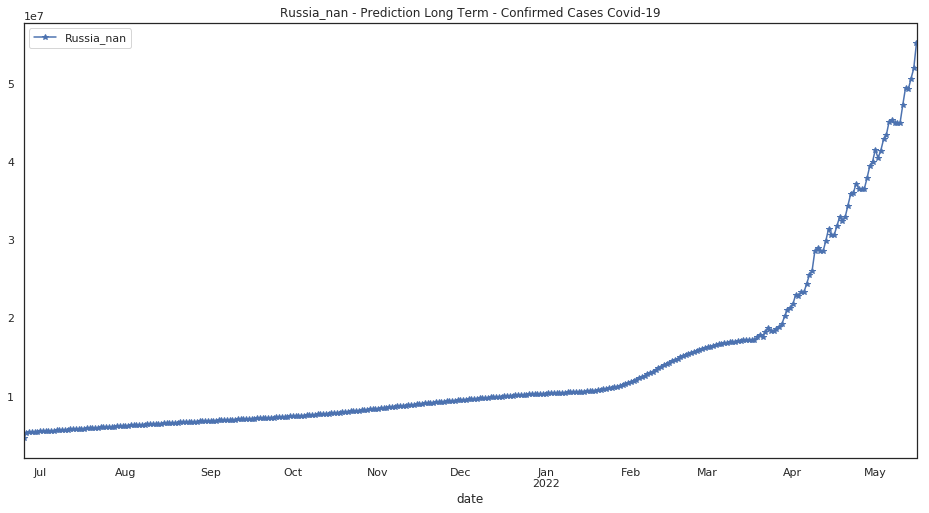

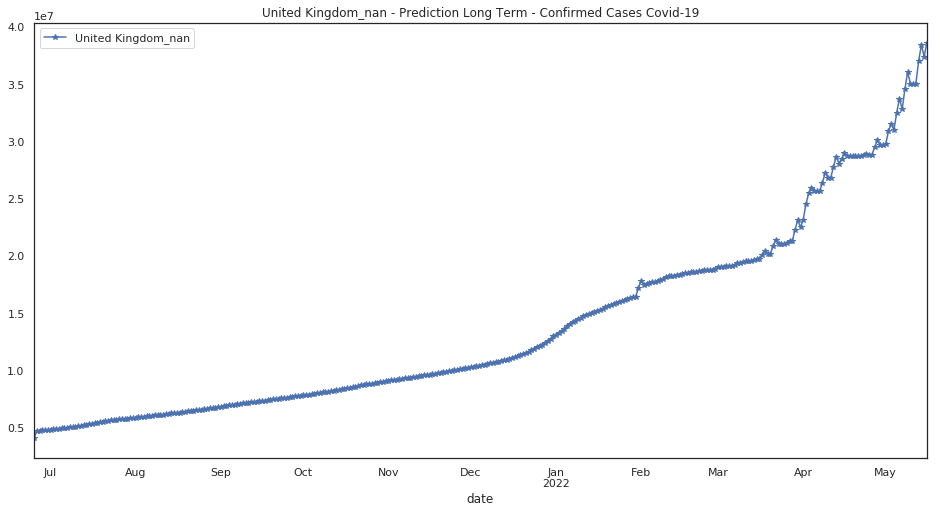

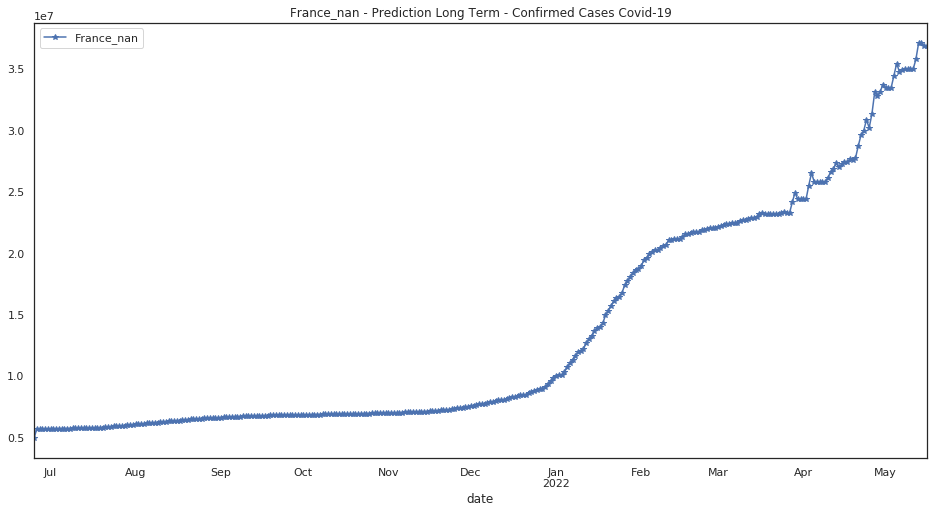

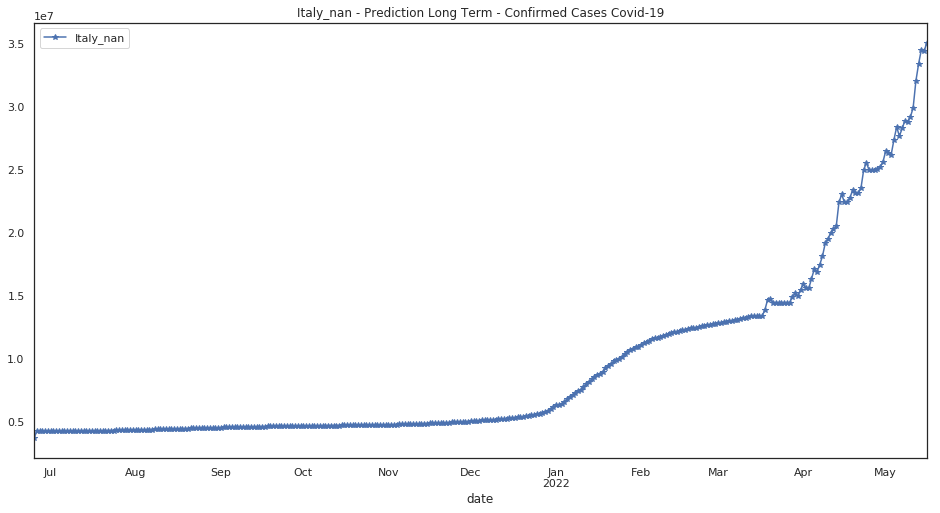

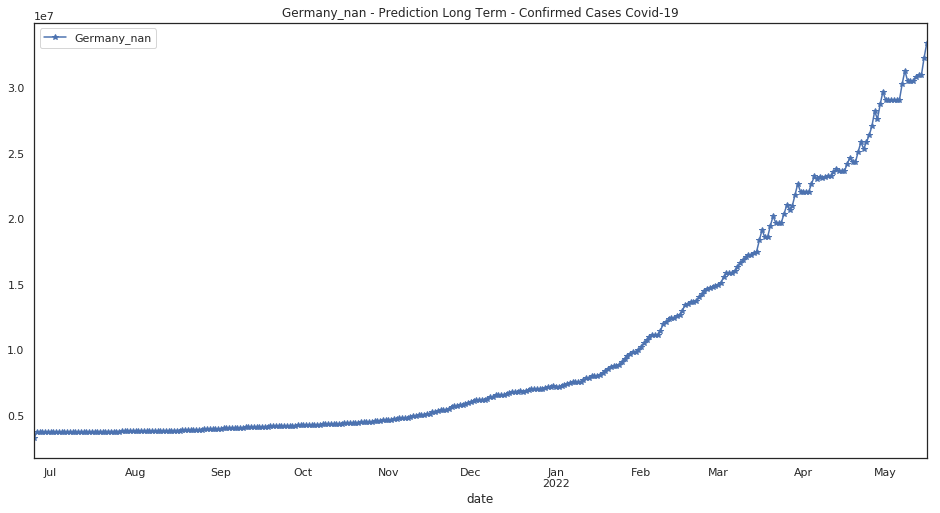

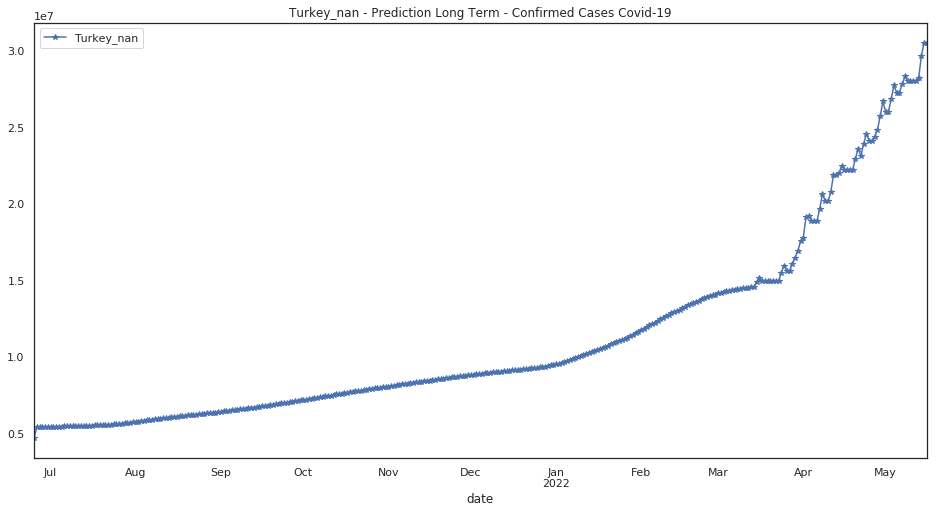

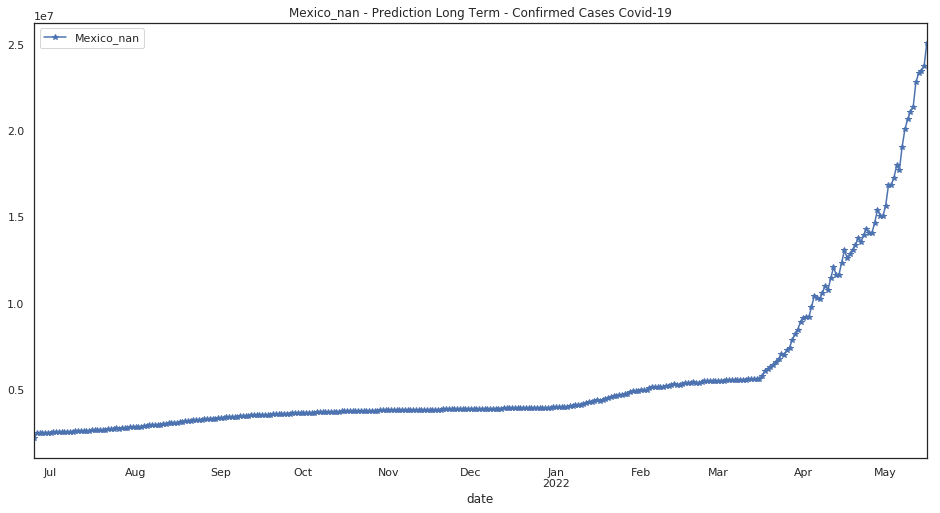

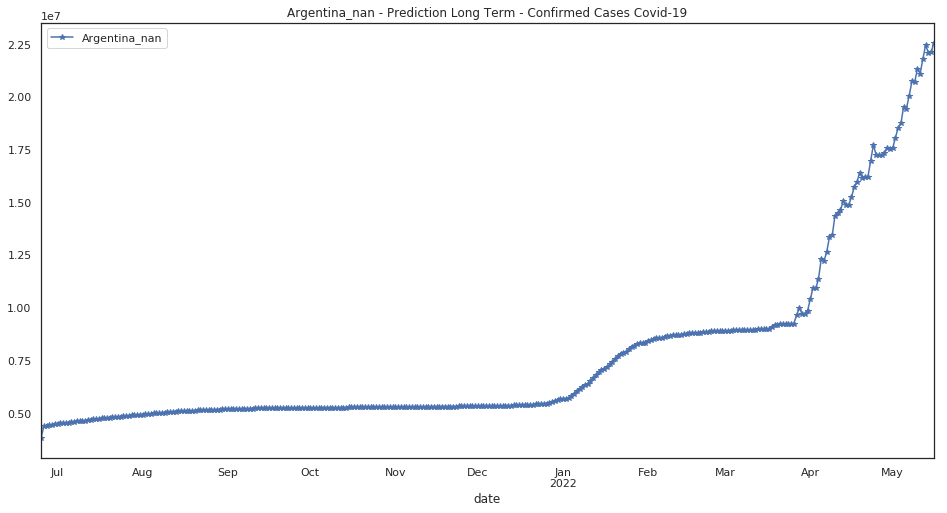

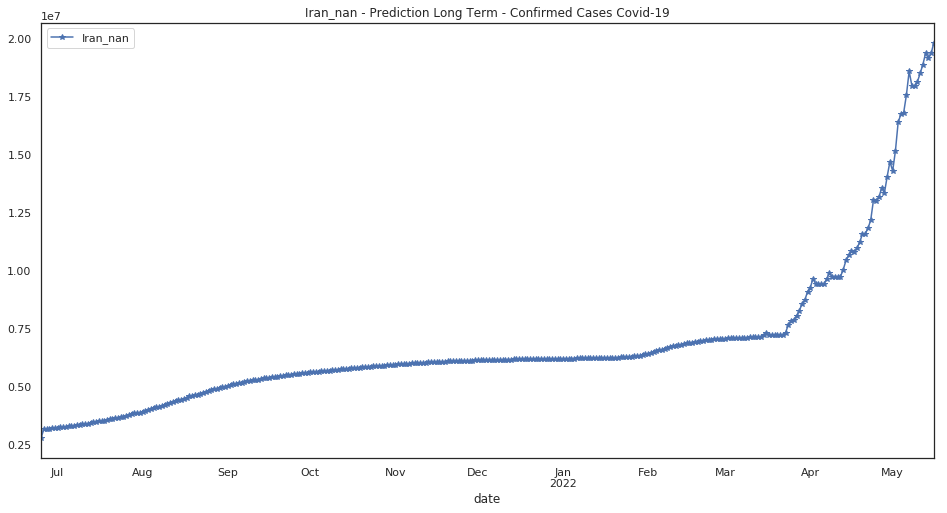

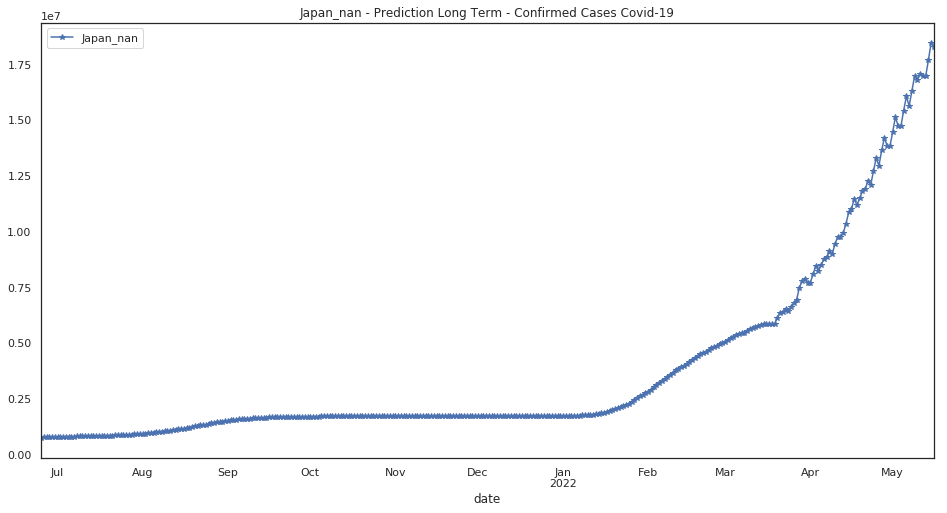

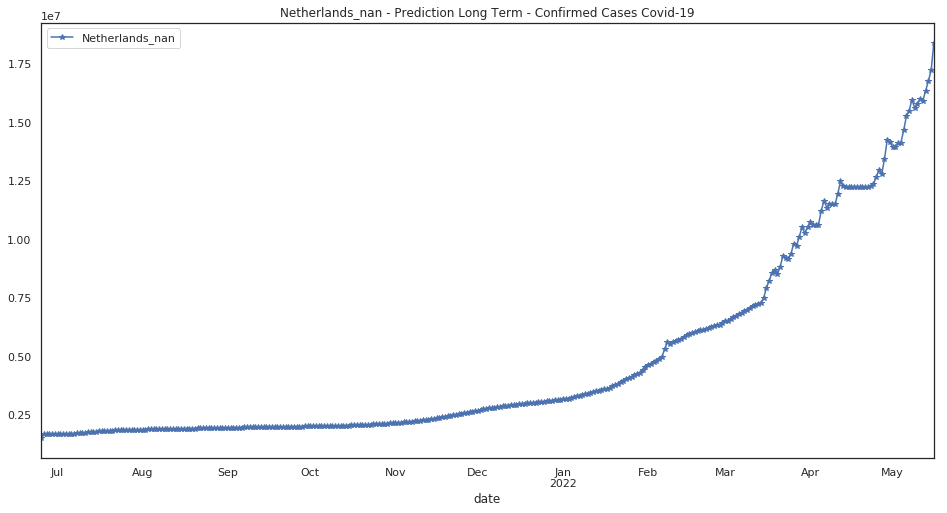

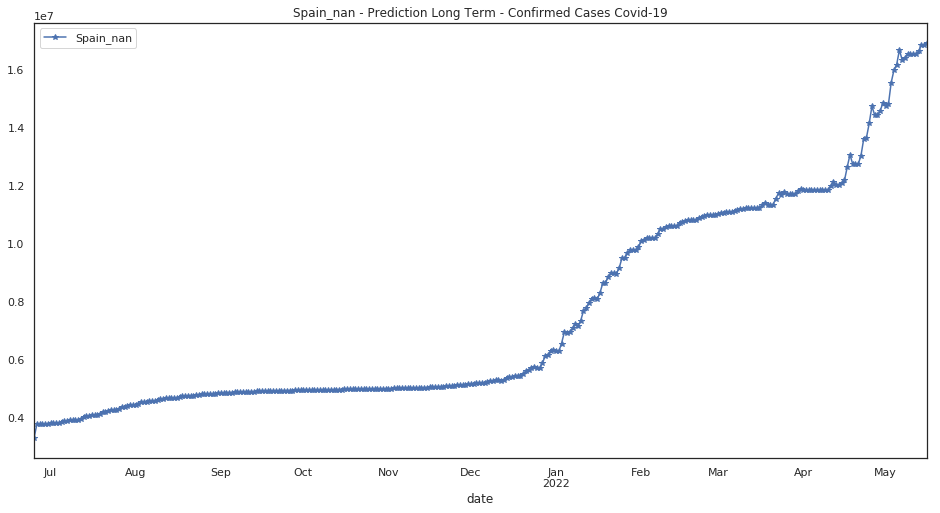

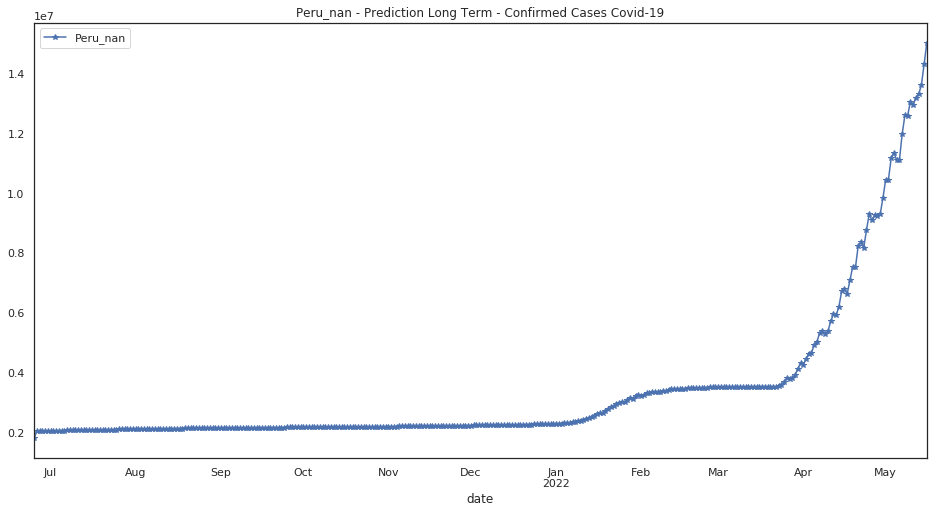

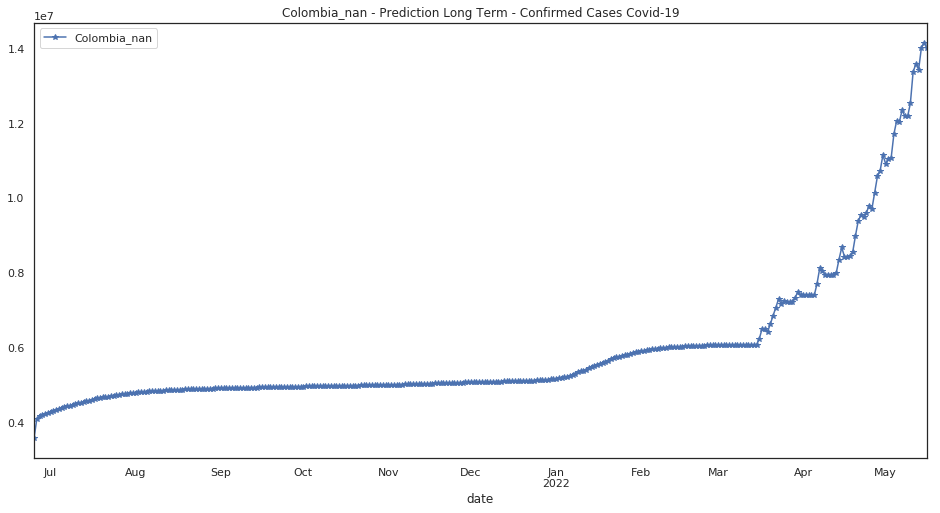

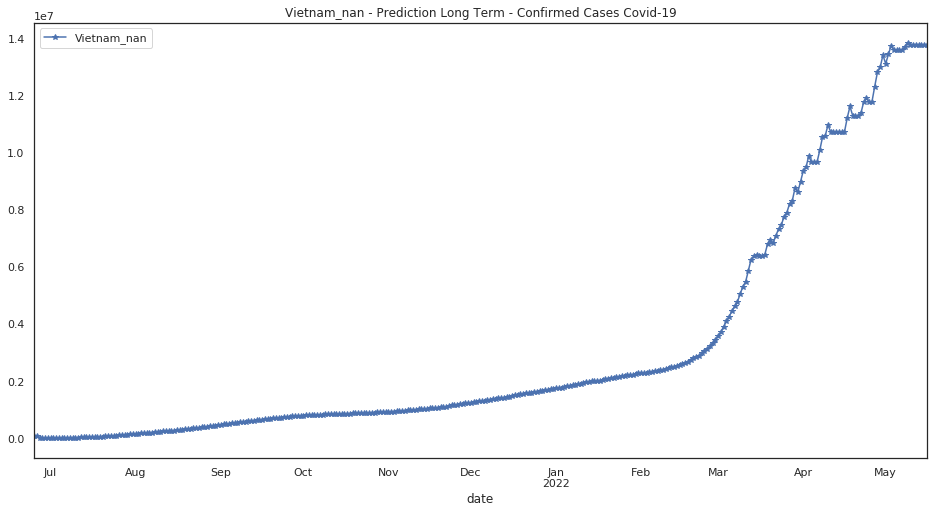

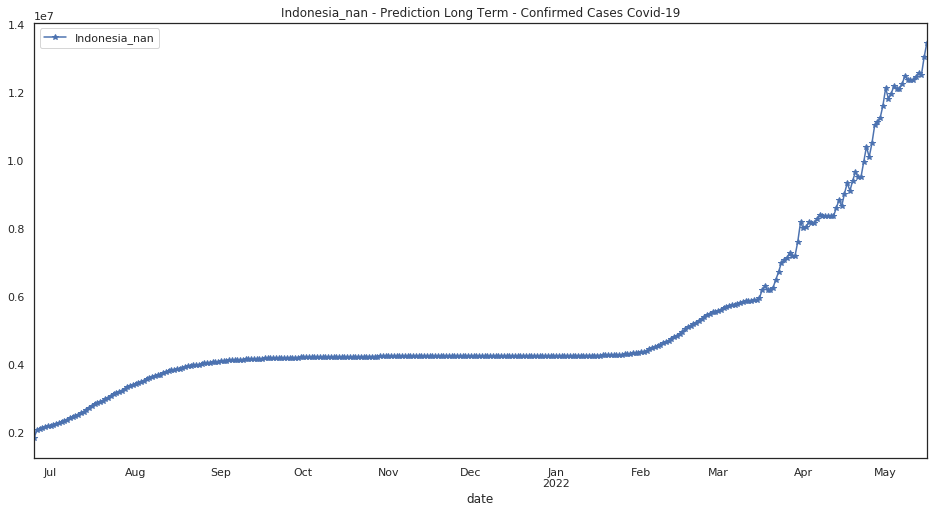

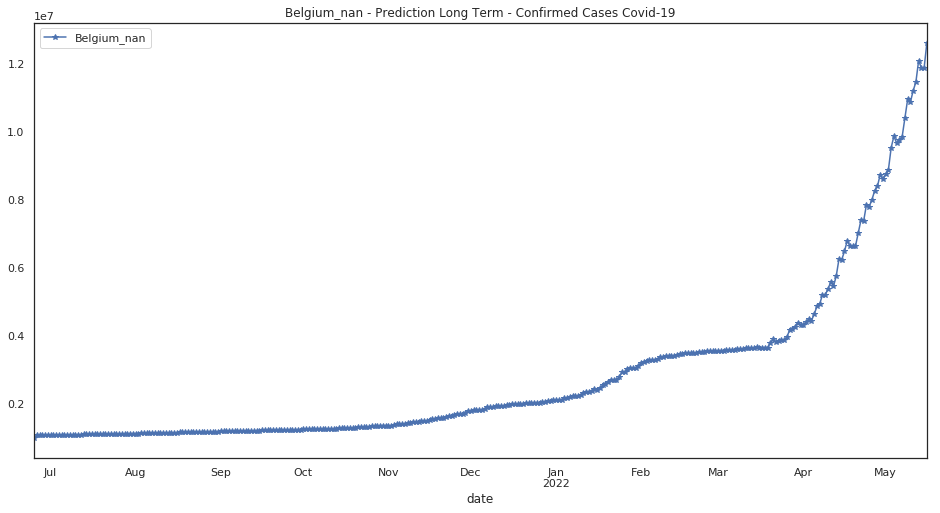

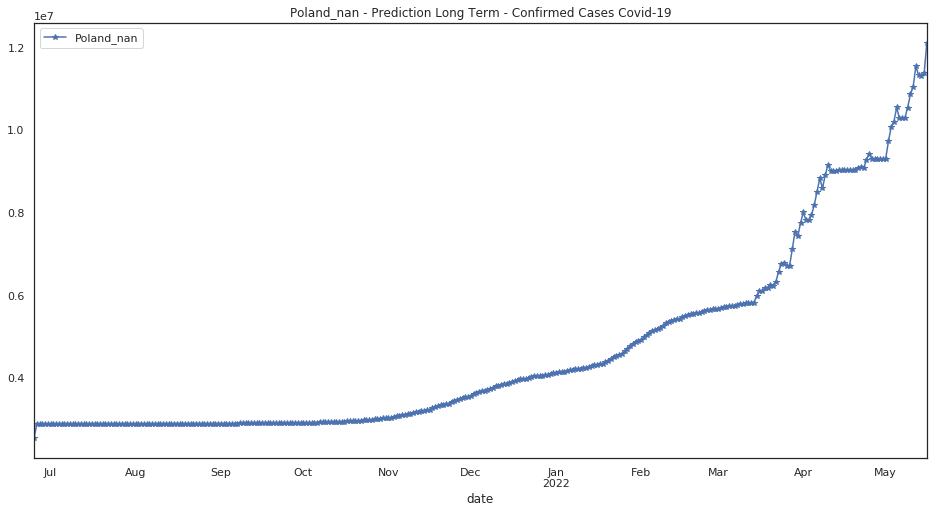

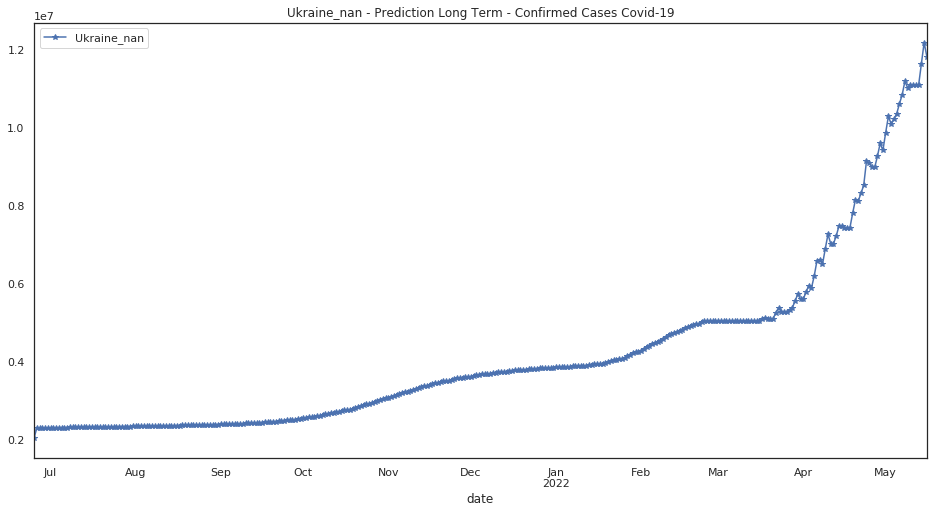

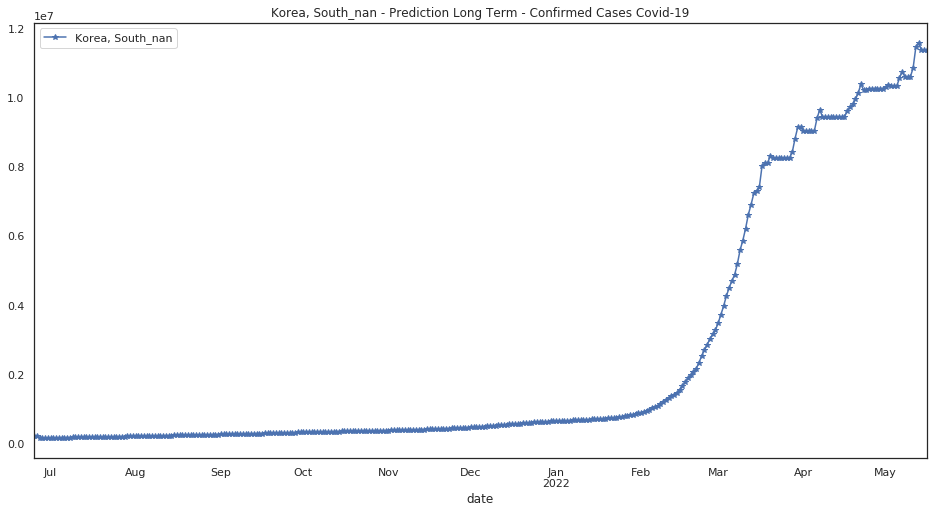

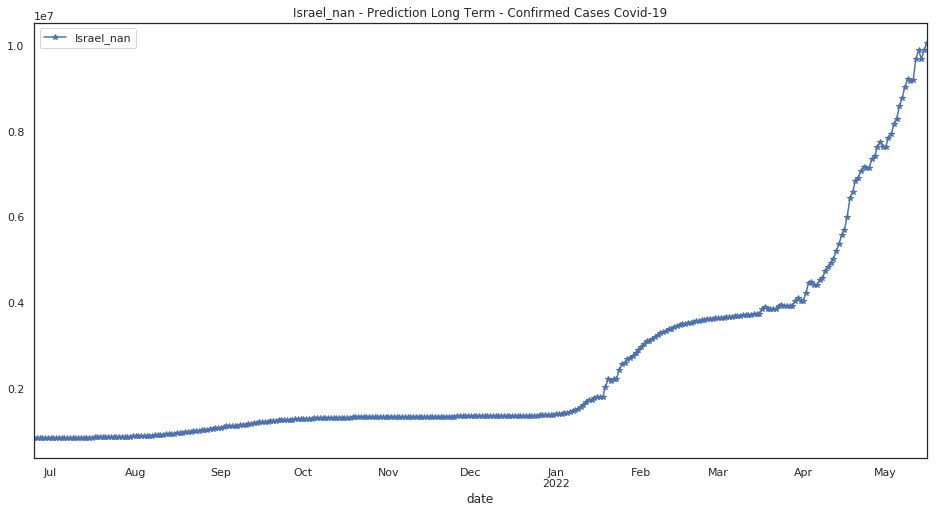

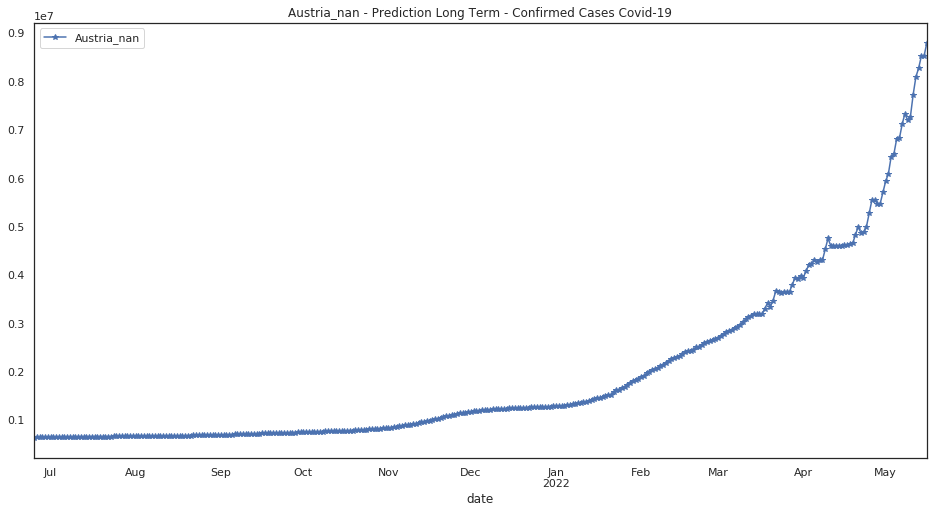

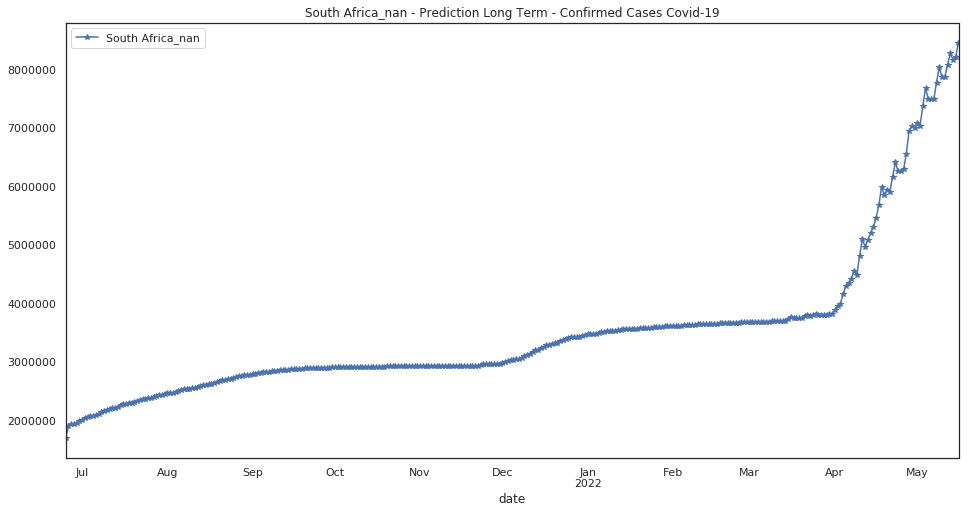

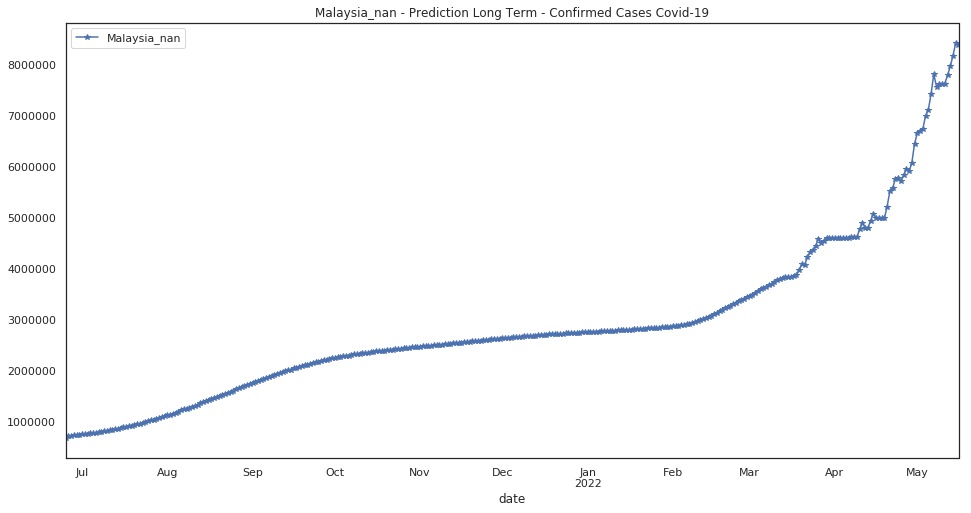

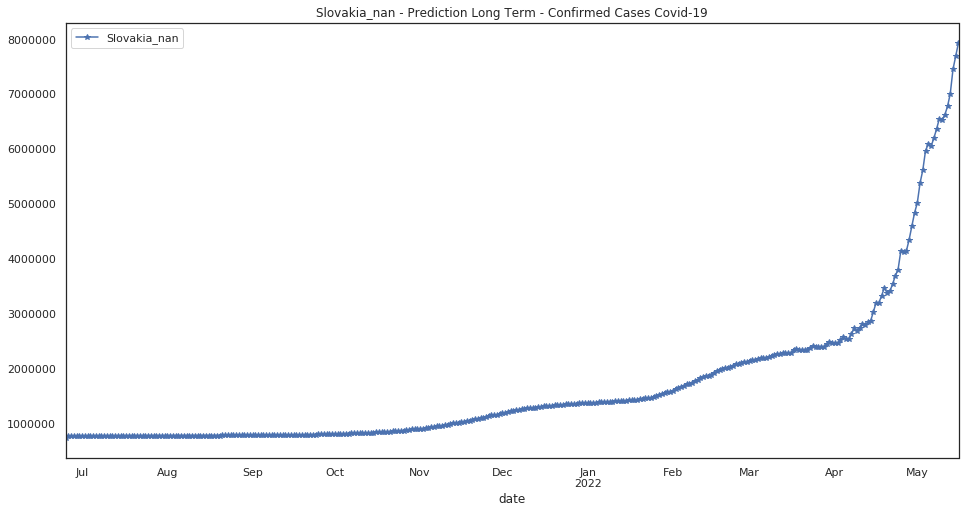

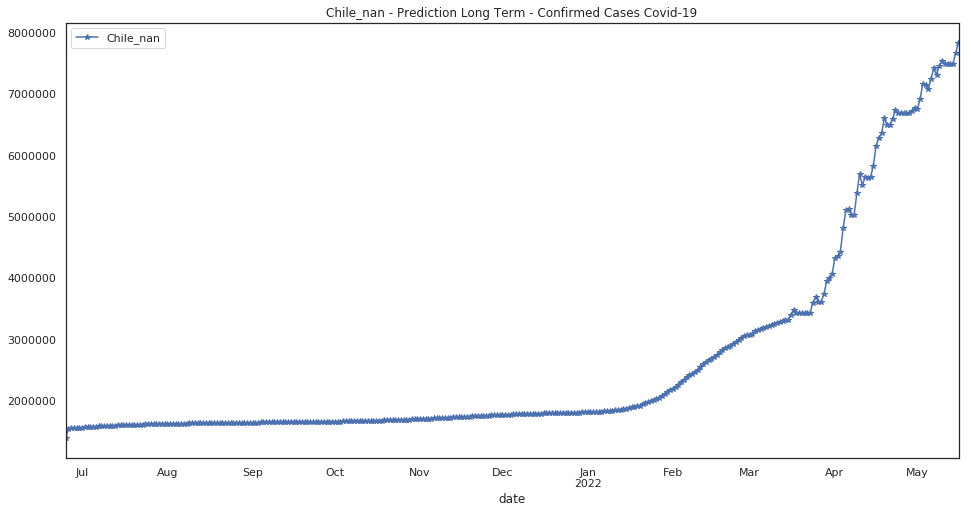

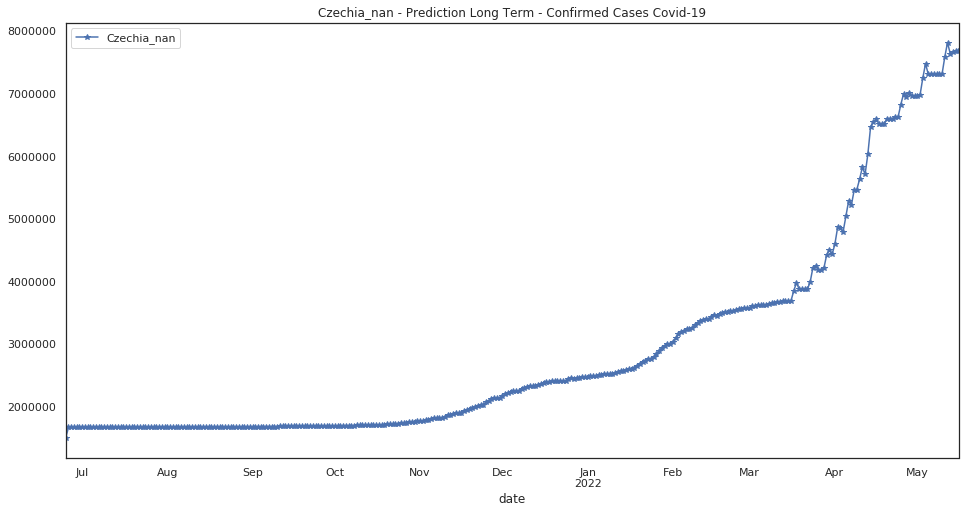

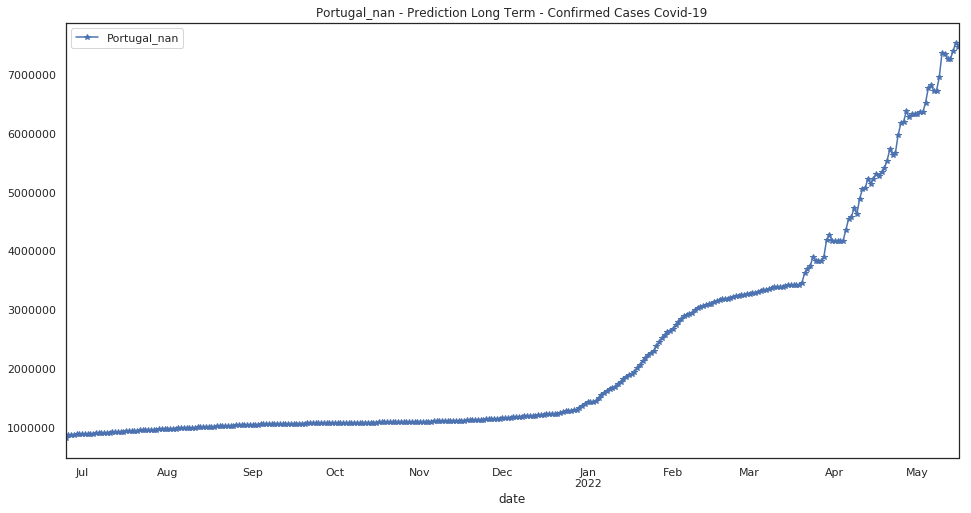

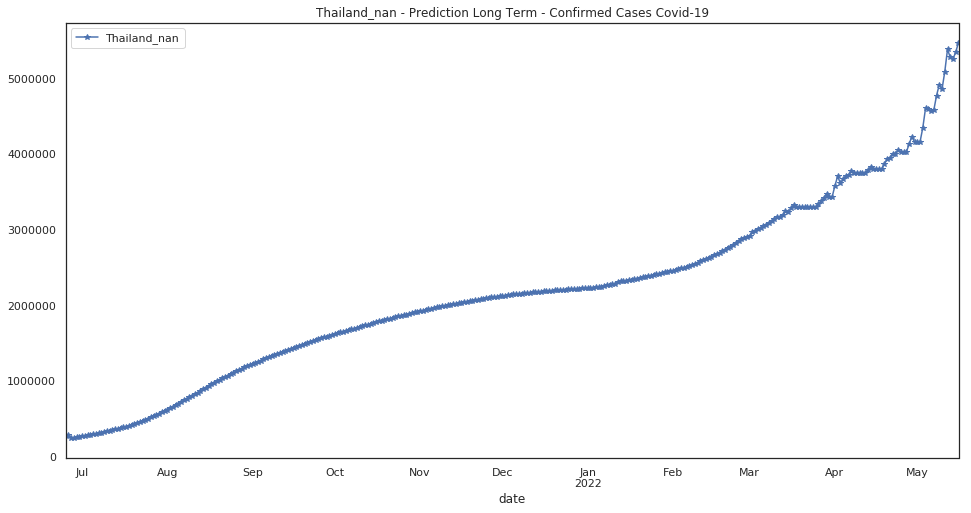

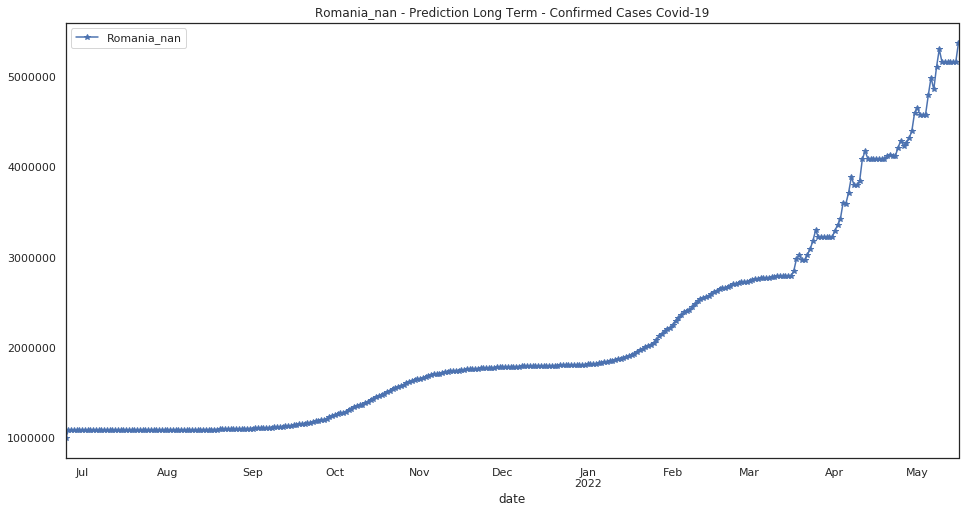

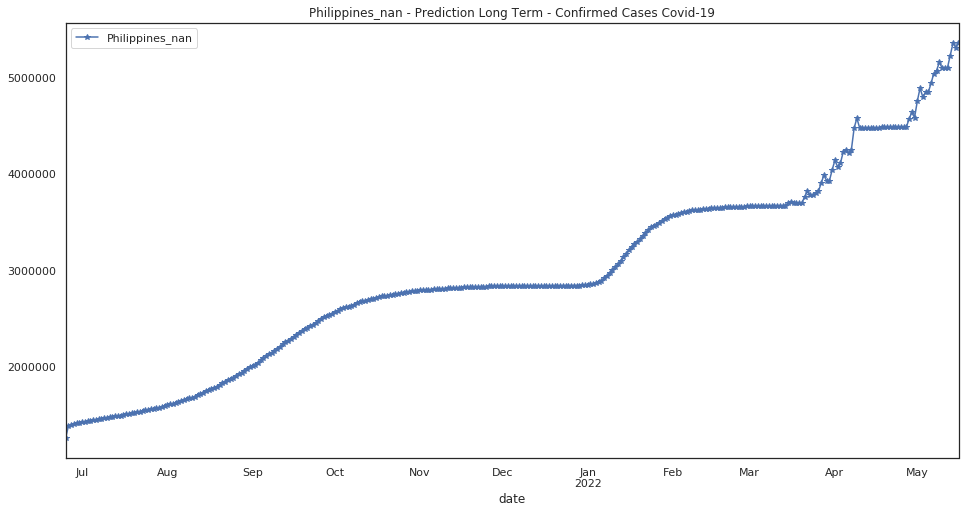

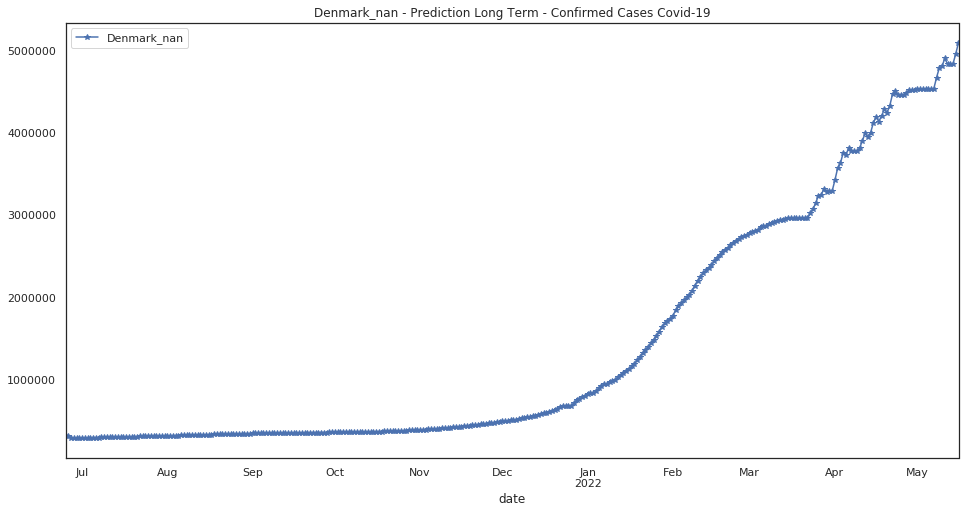

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

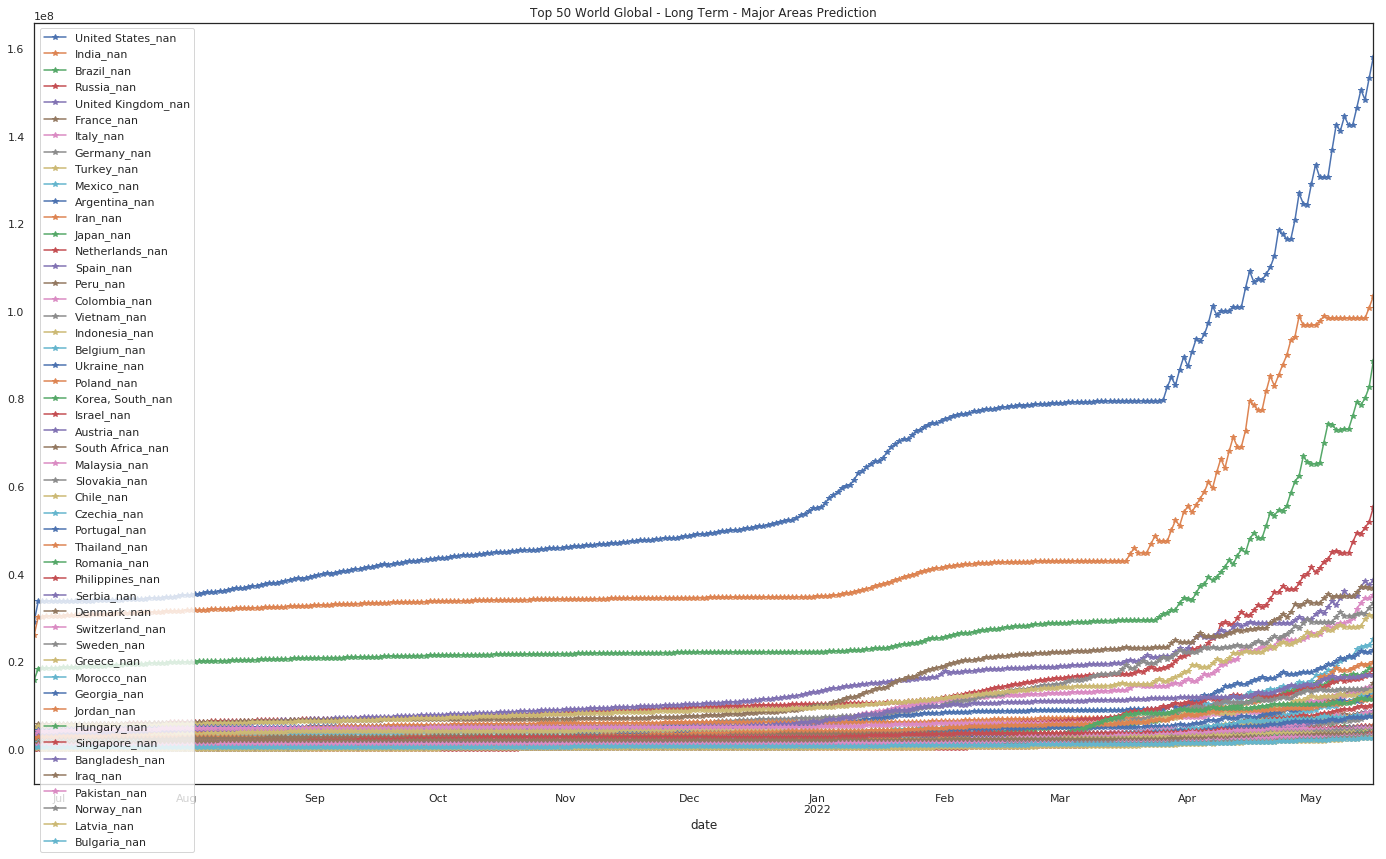

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

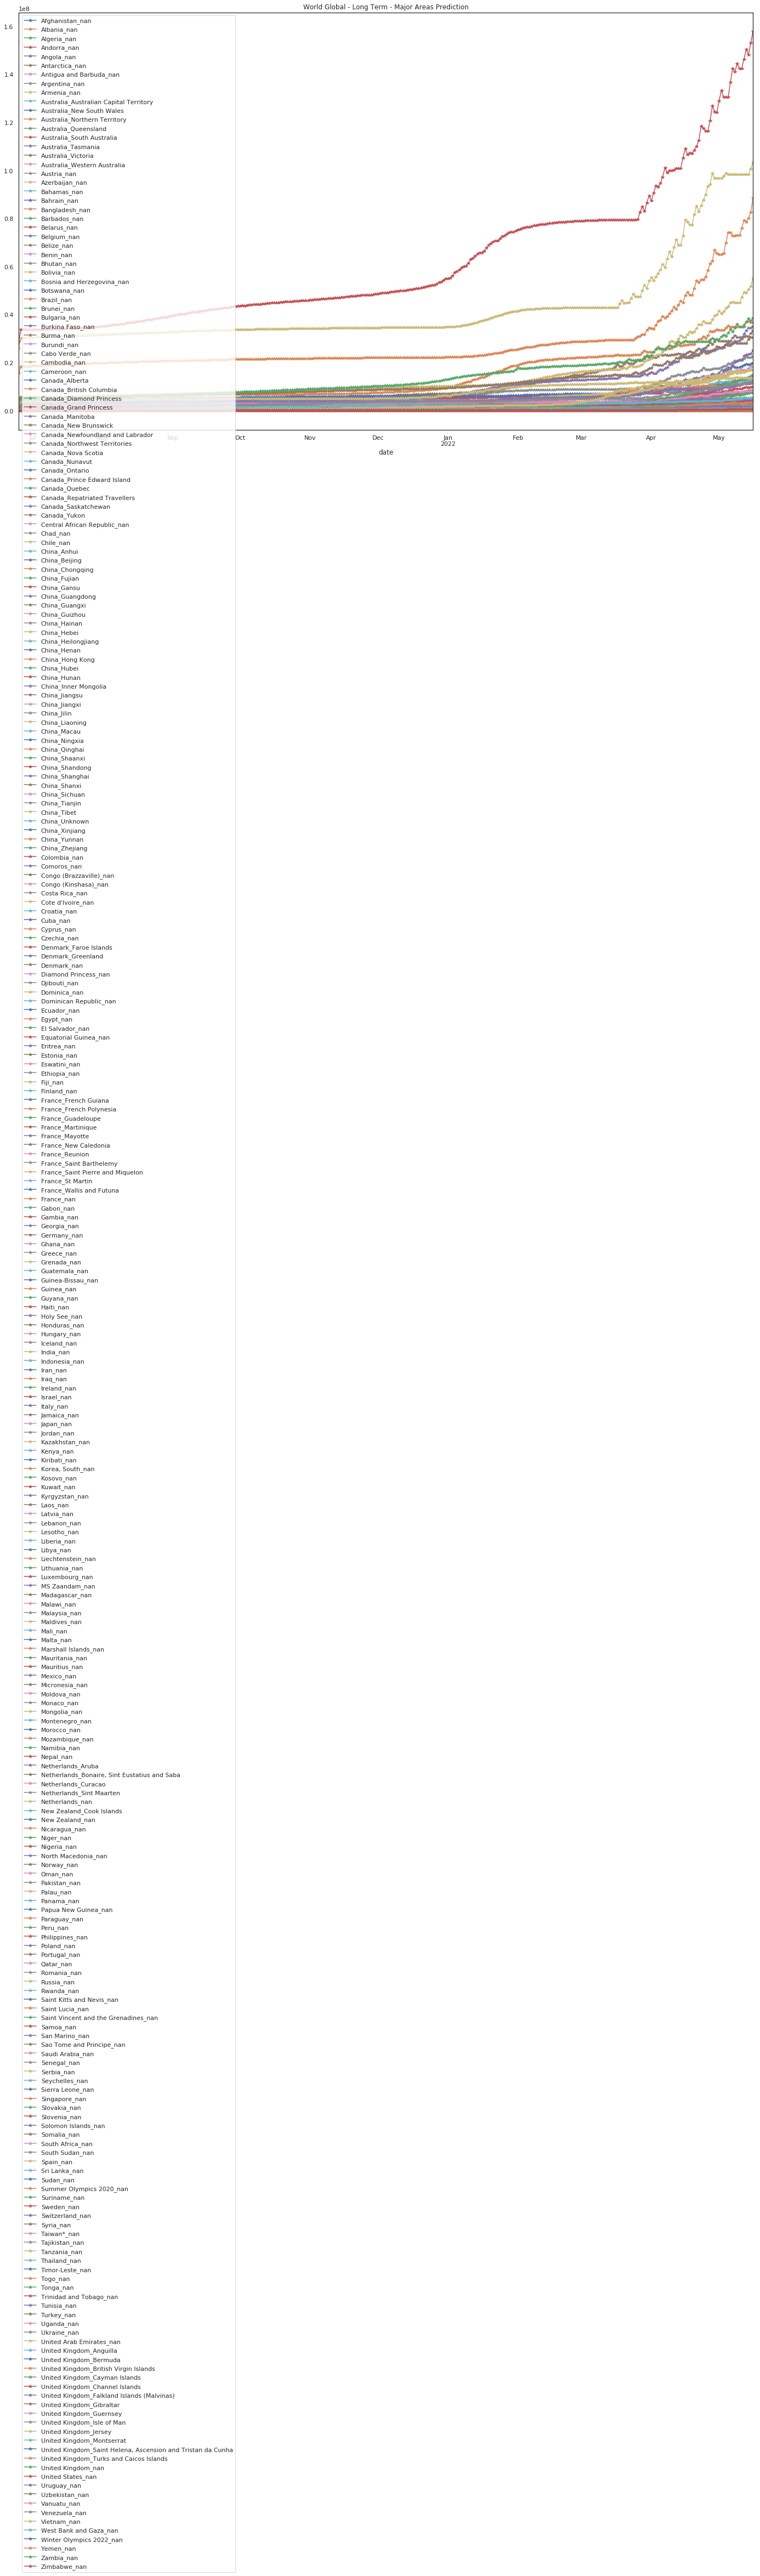

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-08-09         152082.0     135062.0     183484.0      14836.0   
2021-08-10         152343.0     135244.0     184471.0      14836.0   
2021-08-11         152615.0     135526.0     185344.0      14873.0   
2021-08-12         152903.0     135800.0     186199.0      14891.0   
2021-08-13         153125.0     136168.0     187080.0      14908.0   
2021-08-14         153307.0     136576.0     187866.0      14924.0   
2021-08-15         153415.0     136968.0     188489.0      14924.0   
2021-08-16         153508.0     137189.0     189164.0      14924.0   
2021-08-17         153620.0     137569.0     189894.0      14954.0   
2021-08-18         153740.0     138047.0     190624.0      14960.0   
2021-08-19         153813.0     138557.0     191344.0      14976.0   
2021-08-20         153853.0     139099.0     191942.0      14981.0   
2021-08-21         153906.0     139735.0     192453.0      14988.0   
2021-08-22         153929.0     140292.0     192868.0      14988.0   
2021-08-23         153992.0     140690.0     193333.0      14988.0   
2021-08-24         154080.0     141398.0     193896.0      15002.0   
2021-08-25         154148.0     142256.0     194459.0      15003.0   
2021-08-26         154248.0     143138.0     194991.0      15014.0   
2021-08-27         154384.0     144068.0     195505.0      15016.0   
2021-08-28         154446.0     144961.0     195999.0      15025.0   
2021-08-29         154463.0     145734.0     196481.0      15025.0   
2021-08-30         154556.0     146222.0     196900.0      15025.0   
2021-08-31         154642.0     147131.0     197374.0      15032.0   
2021-09-01         154683.0     148174.0     197855.0      15033.0   
2021-09-02         154726.0     149042.0     198241.0      15046.0   
2021-09-03         154791.0     149944.0     198626.0      15052.0   
2021-09-04         154826.0     150910.0     198985.0      15055.0   
2021-09-05         154846.0     151822.0     199324.0      15055.0   
2021-09-06         154945.0     152363.0     199644.0      15055.0   
2021-09-07         155054.0     152993.0     199966.0      15069.0   
...                     ...          ...          ...          ...   
2022-04-17         239638.0     420548.0     437792.0      56236.0   
2022-04-18         237549.0     420548.0     437792.0      56236.0   
2022-04-19         238234.0     431930.0     437792.0      56236.0   
2022-04-20         241916.0     444151.0     437792.0      56277.0   
2022-04-21         256206.0     439850.0     437792.0      56277.0   
2022-04-22         265652.0     438981.0     437792.0      57112.0   
2022-04-23         264497.0     441122.0     437792.0      58501.0   
2022-04-24         262954.0     443005.0     437792.0      60165.0   
2022-04-25         270774.0     442726.0     437792.0      60165.0   
2022-04-26         275094.0     442726.0     445062.0      62277.0   
2022-04-27         277630.0     457923.0     449790.0      62277.0   
2022-04-28         281202.0     468380.0     456875.0      62277.0   
2022-04-29         288408.0     460969.0     463935.0      62277.0   
2022-04-30         293907.0     463733.0     457924.0      63918.0   
2022-05-01         289823.0     465244.0     457924.0      63918.0   
2022-05-02         289823.0     464915.0     476259.0      63918.0   
2022-05-03         294682.0     467109.0     499746.0      64787.0   
2022-05-04         297352.0     469284.0     497814.0      64787.0   
2022-05-05         305890.0     469140.0     492449.0      65888.0   
2022-05-06         311553.0     470764.0     492449.0      66156.0   
2022-05-07         307808.0     471858.0     492449.0      66950.0   
2022-05-08         316108.0     471476.0     503661.0      66950.0   
2022-05-09         320474.0     471476.0     512106.0      66950.0   
2022-05-10         326617.0     484703.0     507103.0      69586.0   
2022-05-11

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
260                                        Tunisia_nan  33.886917    9.537499   
261                                         Turkey_nan  38.963700   35.243300   
262                                  United States_nan  40.000000 -100.000000   
263                                         Uganda_nan   1.373333   32.290275   
264                                        Ukraine_nan  48.379400   31.165600   
265                           United Arab Emirates_nan  23.424076   53.847818   
266                            United Kingdom_Anguilla  18.220600  -63.068600   
267                             United Kingdom_Bermuda  32.307800  -64.750500   
268              United Kingdom_British Virgin Islands  18.420700  -64.640000   
269                      United Kingdom_Cayman Islands  19.313300  -81.254600   
270                     United Kingdom_Channel Islands  49.372300   -2.364400   
271         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
272                           United Kingdom_Gibraltar  36.140800   -5.353600   
273                            United Kingdom_Guernsey  49.448196   -2.589490   
274                         United Kingdom_Isle of Man  54.236100   -4.548100   
275                              United Kingdom_Jersey  49.213800   -2.135800   
276                          United Kingdom_Montserrat  16.742498  -62.187366   
277  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index              region        Lat        Long  2021-06-25 00:00:00  \
0       7       Argentina_nan -38.416100  -63.616700            3825324.0   
1      17         Austria_nan  47.516200   14.550100             626960.0   
2      21      Bangladesh_nan  23.685000   90.356300             823425.0   
3      24         Belgium_nan  50.833300    4.469936             998322.0   
4      31          Brazil_nan -14.235000  -51.925300           15811259.0   
5      60           Chile_nan -35.675100  -71.543000            1389036.0   
6      95        Colombia_nan   4.570900  -74.297300            3583302.0   
7     101         Croatia_nan  45.100000   15.200000             377506.0   
8     104         Czechia_nan  49.817500   15.473000            1499995.0   
9     107         Denmark_nan  56.263900    9.501800             320018.0   
10    133          France_nan  46.227600    2.213700            4963327.0   
11    136         Georgia_nan  42.315400   43.356900             379792.0   
12    137         Georgia_nan  42.315400   43.356900             379792.0   
13    138         Germany_nan  51.165691   10.451526            3274952.0   
14    140          Greece_nan  39.074200   21.824300             429694.0   
15    150         Hungary_nan  47.162500   19.503300             762547.0   
16    152           India_nan  20.593684   78.962880           25987650.0   
17    153       Indonesia_nan  -0.789300  113.921300            1848791.0   
18    154            Iran_nan  32.427908   53.688046            2774562.0   
19    155            Iraq_nan  33.223191   43.679291            1199213.0   
20    157          Israel_nan  31.046051   34.851612             840638.0   
21    158          Israel_nan  31.046051   34.851612             840638.0   
22    159           Italy_nan  41.871940   12.567380            3723879.0   
23    161           Japan_nan  36.204824  138.252924             749288.0   
24    162          Jordan_nan  31.240000   36.510000             711999.0   
25    166    Korea, South_nan  35.907757  127.766922             201414.0   
26    171          Latvia_nan  56.879600   24.603200             186535.0   
27    183        Malaysia_nan   4.210484  101.975766             689340.0   
28    190          Mexico_nan  23.634500 -102.552800            2214168.0   
29    196         Morocco_nan  31.791700   -7.092600             522810.0   
30    204     Netherlands_nan  52.132600    5.291300            1513809.0   
31    211          Norway_nan  60.472000    8.468900             180706.0   
32    213        Pakistan_nan  30.375300   69.345100             887862.0   
33    218            Peru_nan  -9.190000  -75.015200            1823369.0   
34    219     Philippines_nan  12.879721  121.774017            1258151.0   
35    220          Poland_nan  51.919400   19.145100            2541437.0   
36    221        Portugal_nan  39.399900   -8.224500             817138.0   
37    223         Romania_nan  45.943200   24.966800             996644.0   
38    224          Russia_nan  61.524010  105.318756            4659500.0   
39    234          Serbia_nan  44.016500   21.005900             683770.0   
40    237       Singapore_nan   1.283300  103.833300             122460.0   
41    238        Slovakia_nan  48.669000   19.699000             734039.0   
42    242    South Africa_nan -30.559500   22.937500            1696830.0   
43    244           Spain_nan  40.463667   -3.749220            3316855.0   
44    249          Sweden_nan  60.128161   18.643501            1003835.0   
45    250     Switzerland_nan  46.818200    8.227500             672035.0   
46    255        Thailand_nan  15.870032  100.992541             271686.0   
47    261          Turkey_nan  38.963700   35.243300            4704904.0   
48    262   United States_nan  40.000000 -100.000000           29030834.0   
49    264         Ukraine_nan  48.379400   31.165600            2040291.0   
50    279  United Kingdom_nan  55.378100   -3.436000            4104650.0   


In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred, parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()